In [1]:
# !pip install pandas==1.5.3
# !pip install numpy==1.26.4
# !pip install matplotlib==3.9.2
# !pip install seaborn==0.13.2
# !pip install shap==0.46.0
# !pip install joblib==1.4.2
# !pip install scikit-learn==1.5.2
# !pip install xgboost==2.1.1
# !pip install lightgbm==4.5.0
# !pip install catboost==1.2.7
# !pip install optuna==4.0.0
# !pip install imbalanced-learn==0.12.3
# !pip install dice-ml==0.11
# !pip install aif360==0.6.1

In [2]:
# add if really needed fow  solsve error warnings
# tensorflow>=2.17.0
# fairlearn>=0.10.0
# inFairness>=0.2.3

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import os
import warnings
from datetime import datetime
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (classification_report, roc_auc_score, confusion_matrix,
                           accuracy_score, precision_score, recall_score, f1_score,
                           roc_curve, precision_recall_curve, auc)
from sklearn.calibration import calibration_curve
from scipy.stats import wilcoxon, friedmanchisquare
import joblib
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
import optuna
import dice_ml
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.datasets import BinaryLabelDataset

# Configuration for reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')  # Changed from 'seaborn-v0_8-paper' to 'default'
plt.rcParams.update({'font.size': 12, 'font.family': 'sans-serif'})
sns.set_palette("husl")

# Create output directory
OUTPUT_DIR = "rill_final_enhanced"
os.makedirs(OUTPUT_DIR, exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/plots", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/data", exist_ok=True)
os.makedirs(f"{OUTPUT_DIR}/models", exist_ok=True)

print("="*80)
print("CUSTOMER CHURN PREDICTION ANALYSIS (ENHANCED FOR Q1-Q2 JOURNAL)")
print("="*80)
print(f"Analysis started at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Output directory: {OUTPUT_DIR}")

D:\cons\memek\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


CUSTOMER CHURN PREDICTION ANALYSIS (ENHANCED FOR Q1-Q2 JOURNAL)
Analysis started at: 2025-07-01 20:21:13
Output directory: rill_final_enhanced


In [4]:

# === STEP 1: DATA LOADING AND EXPLORATION ===
print("\n" + "="*50)
print("STEP 1: DATA LOADING AND EXPLORATION")
print("="*50)

try:
    df = pd.read_csv("dataset/WA_Fn-UseC_-Telco-Customer-Churn_cleaned.csv")
    print(f"✓ Dataset loaded successfully")
    print(f"Dataset shape: {df.shape}")
    print(f"\nDataset Info:")
    print(f"- Total samples: {len(df)}")
    print(f"- Total features: {len(df.columns)}")
    print(f"- Missing values: {df.isnull().sum().sum()}")
except FileNotFoundError:
    print("❌ Dataset file not found. Please check the file path.")
    print("Make sure the dataset is in the 'dataset/' folder")
    exit()


STEP 1: DATA LOADING AND EXPLORATION
✓ Dataset loaded successfully
Dataset shape: (7043, 21)

Dataset Info:
- Total samples: 7043
- Total features: 21
- Missing values: 0



STEP 2: DATA PREPROCESSING
✓ Column names normalized
Processing TotalCharges column...
Missing values in TotalCharges: 0
Final dataset shape: (7043, 21)
✓ Customer ID column removed

Target Variable Distribution:
- No: 5174 (73.46%)
- Yes: 1869 (26.54%)


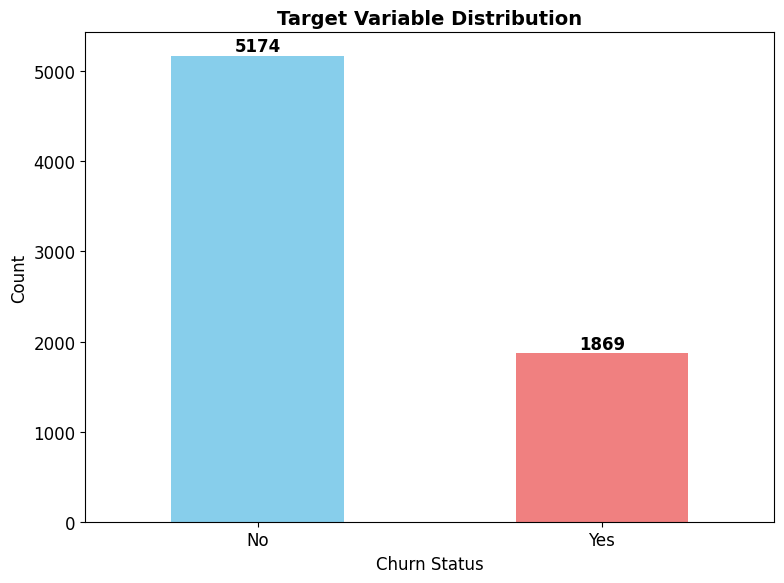

In [5]:
# === STEP 2: DATA PREPROCESSING ===
print("\n" + "="*50)
print("STEP 2: DATA PREPROCESSING")
print("="*50)

# Normalize column names
df.columns = df.columns.str.strip().str.replace(" ", "_")
print("✓ Column names normalized")

# Handle TotalCharges conversion
print("Processing TotalCharges column...")
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    missing_before = df['TotalCharges'].isnull().sum()
    print(f"Missing values in TotalCharges: {missing_before}")

    # Remove rows with missing values
    if missing_before > 0:
        df.dropna(inplace=True)
        print(f"✓ Removed {missing_before} rows with missing values")
else:
    print("TotalCharges column not found")

print(f"Final dataset shape: {df.shape}")

# Remove customer ID
if 'customerID' in df.columns:
    df.drop(['customerID'], axis=1, inplace=True)
    print("✓ Customer ID column removed")

# Analyze target variable distribution
if 'Churn' not in df.columns:
    print("❌ Churn column not found in dataset")
    print(f"Available columns: {list(df.columns)}")
    exit()

target_dist = df['Churn'].value_counts()
print(f"\nTarget Variable Distribution:")
for label, count in target_dist.items():
    percentage = (count / len(df)) * 100
    print(f"- {label}: {count} ({percentage:.2f}%)")

# Create class distribution plot
plt.figure(figsize=(8, 6))
target_dist.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Target Variable Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Churn Status')
plt.ylabel('Count')
plt.xticks(rotation=0)
for i, v in enumerate(target_dist.values):
    plt.text(i, v + 50, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/target_distribution.png", dpi=300, bbox_inches='tight')
plt.show()



STEP 3: FEATURE ENGINEERING
✓ Saved dataset copy without feature engineering
✓ Added Engagement_Score feature
✓ Added Churn_Risk_Score feature
✓ Added Service_Utilization feature
✓ Added Payment_Reliability feature
Categorical features to encode: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
✓ One-hot encoding completed
Features after encoding: 34
✓ One-hot encoding completed for dataset without feature engineering
Final feature matrix shape (without FE): (7043, 30)
Final feature matrix shape: (7043, 34)
Target variable shape: (7043,)


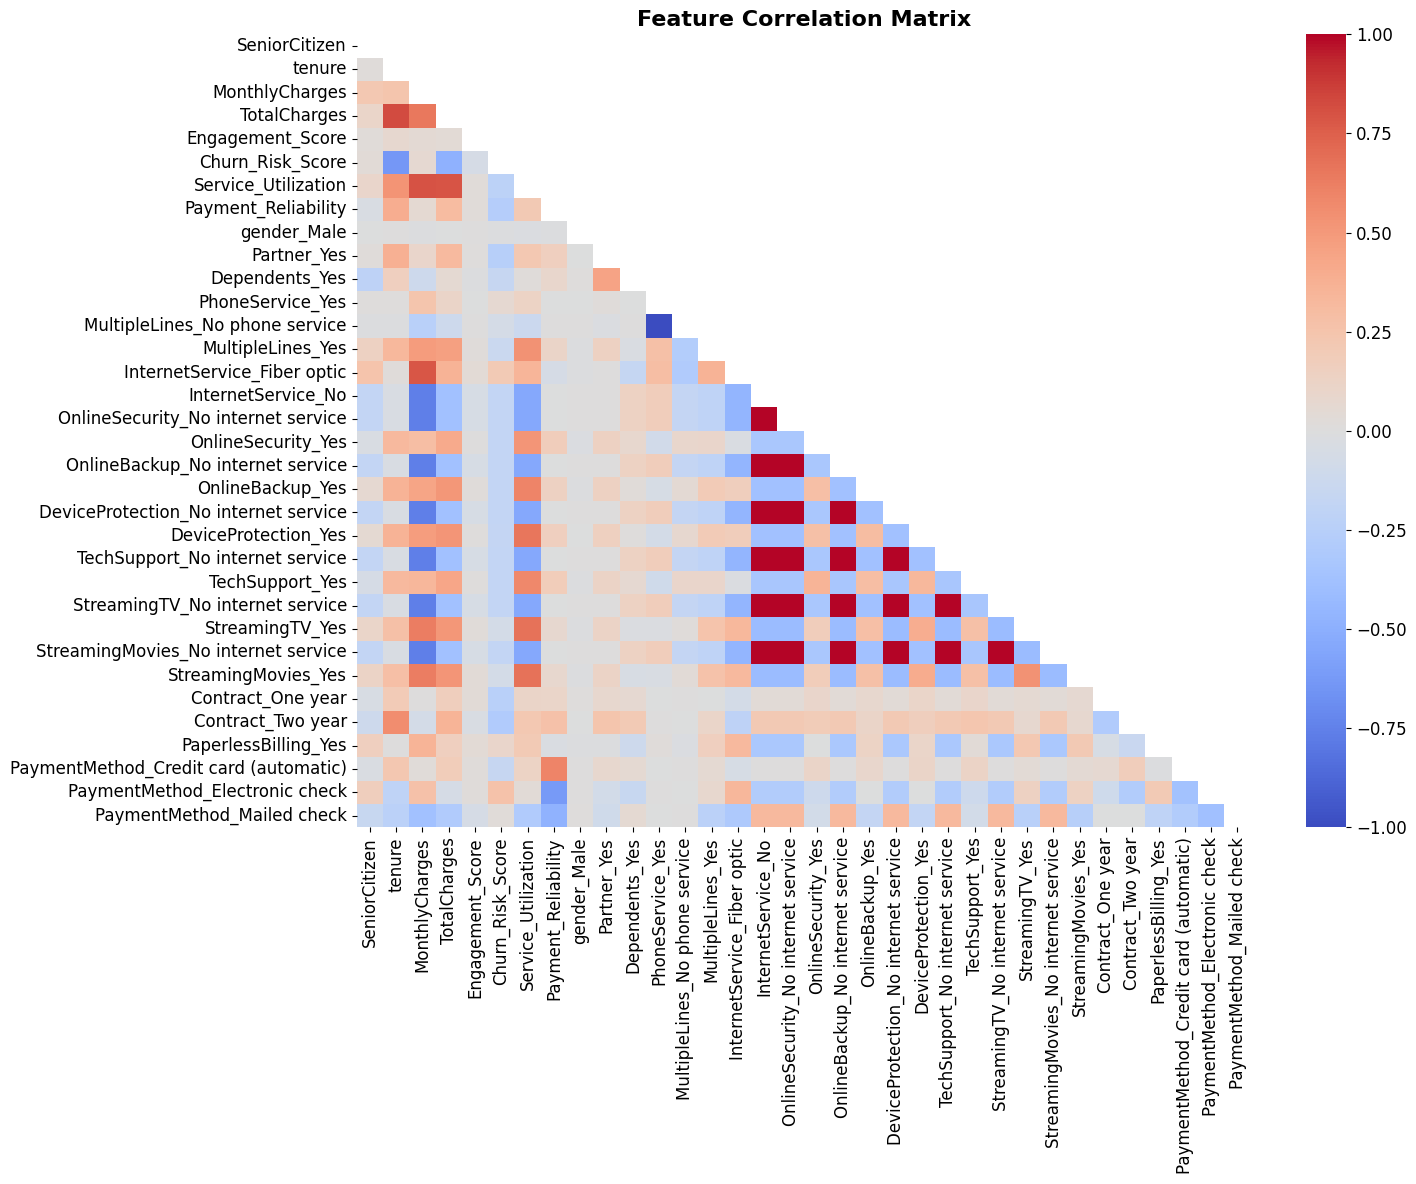

In [6]:

# === STEP 3: FEATURE ENGINEERING ===
print("\n" + "="*50)
print("STEP 3: FEATURE ENGINEERING")
print("="*50)

# Save a copy of the dataset before feature engineering for comparative analysis
df_no_fe = df.copy()
print("✓ Saved dataset copy without feature engineering")

# Check if required columns exist before feature engineering
required_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    print(f"⚠ Missing required columns for feature engineering: {missing_cols}")
    print("Skipping advanced feature engineering...")
else:
    # New feature: Engagement Score
    df['Engagement_Score'] = df['tenure'] * df['MonthlyCharges'] / (df['TotalCharges'] + 1)
    print("✓ Added Engagement_Score feature")

    # New feature: Churn Risk Score
    df['Churn_Risk_Score'] = df['tenure'].apply(lambda x: 1 if x < 12 else 0) * df['MonthlyCharges']
    print("✓ Added Churn_Risk_Score feature")

# Service utilization (if service columns exist)
service_cols = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
               'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
existing_service_cols = [col for col in service_cols if col in df.columns]
if existing_service_cols:
    df['Service_Utilization'] = df[existing_service_cols].eq('Yes').sum(axis=1)
    print("✓ Added Service_Utilization feature")

# Payment reliability (if payment method column exists)
if 'PaymentMethod' in df.columns:
    df['Payment_Reliability'] = df['PaymentMethod'].apply(
        lambda x: 1 if x in ['Bank transfer (automatic)', 'Credit card (automatic)'] else 0
    )
    print("✓ Added Payment_Reliability feature")

# One-hot encoding for categorical variables
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
if 'Churn' in categorical_features:
    categorical_features.remove('Churn')

print(f"Categorical features to encode: {categorical_features}")
if categorical_features:
    df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)
    print(f"✓ One-hot encoding completed")
else:
    df_encoded = df.copy()
    print("✓ No categorical features to encode")

print(f"Features after encoding: {df_encoded.shape[1] - 1}")


#### TAMBAHAN: Prepare dataset without feature engineering
categorical_features_no_fe = df_no_fe.select_dtypes(include=['object']).columns.tolist()
if 'Churn' in categorical_features_no_fe:
    categorical_features_no_fe.remove('Churn')

if categorical_features_no_fe:
    df_encoded_no_fe = pd.get_dummies(df_no_fe, columns=categorical_features_no_fe, drop_first=True)
    print(f"✓ One-hot encoding completed for dataset without feature engineering")
else:
    df_encoded_no_fe = df_no_fe.copy()
    print("✓ No categorical features to encode for dataset without feature engineering")

# TAMBAHAN: Prepare features and target for no feature engineering
X_no_fe = df_encoded_no_fe.drop("Churn", axis=1)
y_no_fe = (df_encoded_no_fe["Churn"] == "Yes").astype(int)
print(f"Final feature matrix shape (without FE): {X_no_fe.shape}")
####

# Prepare features and target
X = df_encoded.drop("Churn", axis=1)
y = (df_encoded["Churn"] == "Yes").astype(int)
print(f"Final feature matrix shape: {X.shape}")
print(f"Target variable shape: {y.shape}")

# Feature correlation analysis (only if we have multiple features)
if X.shape[1] > 1:
    plt.figure(figsize=(15, 12))
    corr_matrix = X.corr()
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
    sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', center=0)
    plt.title('Feature Correlation Matrix', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/plots/correlation_matrix.png", dpi=300, bbox_inches='tight')
    plt.show()


In [7]:

# === STEP 4: DATA SCALING AND SPLITTING ===
print("\n" + "="*50)
print("STEP 4: DATA SCALING AND SPLITTING")
print("="*50)

# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("✓ Feature scaling completed")

# Save scaler
joblib.dump(scaler, f"{OUTPUT_DIR}/models/scaler.pkl")
print("✓ Scaler saved")

# Compare imbalance handling methods
imbalance_methods = {
    'SMOTE': SMOTE(random_state=RANDOM_SEED),
    'SMOTEENN': SMOTEENN(random_state=RANDOM_SEED),
    'RandomUnderSampler': RandomUnderSampler(random_state=RANDOM_SEED),
    'ADASYN': ADASYN(random_state=RANDOM_SEED)
}

imbalance_results = {}
for name, sampler in imbalance_methods.items():
    try:
        print(f"Applying {name}...")
        X_res, y_res = sampler.fit_resample(X_scaled, y)
        X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(
            X_res, y_res, stratify=y_res, test_size=0.25, random_state=RANDOM_SEED
        )
        imbalance_results[name] = {'shape': X_res.shape, 'target_dist': np.bincount(y_res)}
        print(f"✓ {name} - Resampled shape: {X_res.shape}, Target distribution: {np.bincount(y_res)}")
    except Exception as e:
        print(f"⚠ {name} failed: {str(e)}")
        continue

# Use SMOTE for main analysis
try:
    smote = SMOTE(random_state=RANDOM_SEED)
    X_scaled_res, y_res = smote.fit_resample(X_scaled, y)
    print(f"✓ SMOTE applied - Resampled dataset shape: {X_scaled_res.shape}")
    print(f"Resampled target distribution: {np.bincount(y_res)}")
except Exception as e:
    print(f"⚠ SMOTE failed, using original data: {str(e)}")
    X_scaled_res, y_res = X_scaled, y

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_res, y_res, stratify=y_res, test_size=0.25, random_state=RANDOM_SEED
)
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")
print(f"Training set class distribution: {np.bincount(y_train)}")
print(f"Testing set class distribution: {np.bincount(y_test)}")

# TAMBAHAN: Feature scaling for dataset without feature engineering
X_scaled_no_fe = scaler.fit_transform(X_no_fe)
print("✓ Feature scaling completed for dataset without feature engineering")

# TAMBAHAN: Train-test split for no feature engineering
X_train_no_fe, X_test_no_fe, y_train_no_fe, y_test_no_fe = train_test_split(
    X_scaled_no_fe, y_no_fe, stratify=y_no_fe, test_size=0.25, random_state=RANDOM_SEED
)
print(f"Training set shape (No FE): {X_train_no_fe.shape}")
print(f"Testing set shape (No FE): {X_test_no_fe.shape}")

# TAMBAHAN: Train-test split for feature engineering without SMOTE
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(
    X_scaled, y, stratify=y, test_size=0.25, random_state=RANDOM_SEED
)
print(f"Training set shape (FE only): {X_train_fe.shape}")
print(f"Testing set shape (FE only): {X_test_fe.shape}")


STEP 4: DATA SCALING AND SPLITTING
✓ Feature scaling completed
✓ Scaler saved
Applying SMOTE...
✓ SMOTE - Resampled shape: (10348, 34), Target distribution: [5174 5174]
Applying SMOTEENN...
✓ SMOTEENN - Resampled shape: (6559, 34), Target distribution: [2801 3758]
Applying RandomUnderSampler...
✓ RandomUnderSampler - Resampled shape: (3738, 34), Target distribution: [1869 1869]
Applying ADASYN...
✓ ADASYN - Resampled shape: (10343, 34), Target distribution: [5174 5169]
✓ SMOTE applied - Resampled dataset shape: (10348, 34)
Resampled target distribution: [5174 5174]
Training set shape: (7761, 34)
Testing set shape: (2587, 34)
Training set class distribution: [3880 3881]
Testing set class distribution: [1294 1293]
✓ Feature scaling completed for dataset without feature engineering
Training set shape (No FE): (5282, 30)
Testing set shape (No FE): (1761, 30)
Training set shape (FE only): (5282, 34)
Testing set shape (FE only): (1761, 34)



STEP 4.3: VISUALIZE TARGET DISTRIBUTION AFTER SMOTE

Target Variable Distribution After SMOTE:
- No: 5174 (50.00%)
- Yes: 5174 (50.00%)


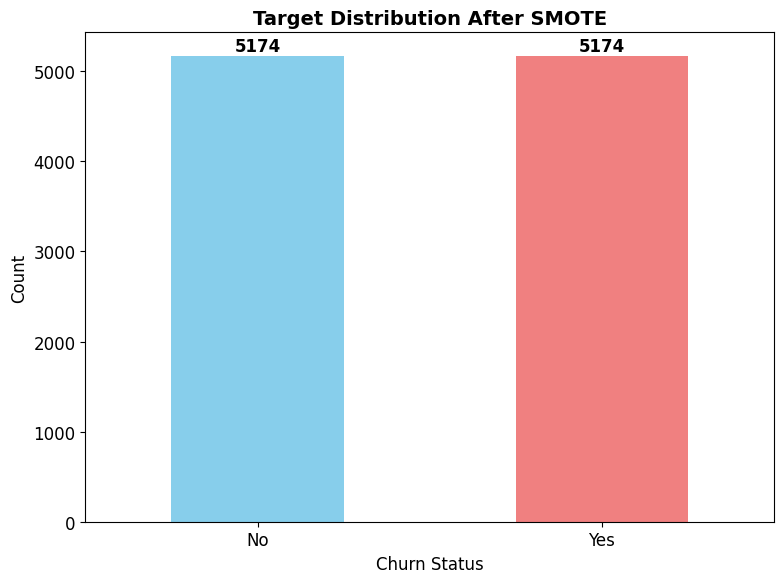

In [8]:
# === STEP 4.3: Visualize target distribution after SMOTE ===
print("\n" + "="*50)
print("STEP 4.3: VISUALIZE TARGET DISTRIBUTION AFTER SMOTE")
print("="*50)

# Create target distribution after SMOTE (sama seperti Step 2)
# Convert numeric to text labels to match Step 2 format
y_res_labels = pd.Series(['No' if x == 0 else 'Yes' for x in y_res])
target_dist = y_res_labels.value_counts()
print(f"\nTarget Variable Distribution After SMOTE:")
for label, count in target_dist.items():
    percentage = (count / len(y_res)) * 100
    print(f"- {label}: {count} ({percentage:.2f}%)")

# Create class distribution plot (identik dengan Step 2)
plt.figure(figsize=(8, 6))
target_dist.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Target Distribution After SMOTE', fontsize=14, fontweight='bold')
plt.xlabel('Churn Status')
plt.ylabel('Count')
plt.xticks(rotation=0)
for i, v in enumerate(target_dist.values):
    plt.text(i, v + 50, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/resampled_target_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

In [9]:
train_now = True  # Set to True to retrain hyperparameters, False to load existing
# === STEP 5: MODEL DEFINITION AND HYPERPARAMETER TUNING ===
print("\n" + "="*50)
print("STEP 5: MODEL DEFINITION AND HYPERPARAMETER TUNING")
print("="*50)

# Define models with expanded hyperparameter grids
models_config = {
    "DecisionTree": {
        "model": DecisionTreeClassifier(random_state=RANDOM_SEED),
        "params": {'max_depth': [3, 5, 7], 'min_samples_split': [2, 5]}
    },
    "GBM": {
        "model": GradientBoostingClassifier(random_state=RANDOM_SEED),
        "params": {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
    },
    "XGBoost": {
        "model": XGBClassifier(eval_metric='logloss', random_state=RANDOM_SEED, verbosity=0),
        "params": {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
    },
    "RandomForest": {
        "model": RandomForestClassifier(random_state=RANDOM_SEED),
        "params": {'n_estimators': [100, 200], 'max_depth': [10, None], 'min_samples_split': [2, 5]}
    },
    "LogisticRegression": {
        "model": LogisticRegression(max_iter=1000, random_state=RANDOM_SEED),
        "params": {'C': [0.1, 1, 10], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
    },
    "SVC": {
        "model": SVC(probability=True, random_state=RANDOM_SEED),
        "params": {'C': [0.1, 1], 'kernel': ['rbf', 'linear']}
    },
    "NeuralNet": {
        "model": MLPClassifier(max_iter=200, random_state=RANDOM_SEED, early_stopping=True),
        "params": {'hidden_layer_sizes': [(50,), (100,), (50, 50)], 'alpha': [0.0001, 0.001]}
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(random_state=RANDOM_SEED),
        "params": {'n_estimators': [50, 100], 'learning_rate': [0.1, 1.0]}
    },
    "LightGBM": {
        "model": LGBMClassifier(random_state=RANDOM_SEED, verbosity=-1),
        "params": {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 'max_depth': [3, 5]}
    },
    "CatBoost": {
        "model": CatBoostClassifier(random_state=RANDOM_SEED, verbose=0),
        "params": {'iterations': [100, 200], 'learning_rate': [0.01, 0.1], 'depth': [3, 5]}
    }
}

def objective(trial, model_name, X_train, y_train):
    params = {}
    try:
        if model_name == "XGBoost":
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 500),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'subsample': trial.suggest_float('subsample', 0.6, 1.0)
            }
            model = XGBClassifier(**params, random_state=RANDOM_SEED, eval_metric='logloss', verbosity=0)
        elif model_name == "LightGBM":
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 500),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'max_depth': trial.suggest_int('max_depth', 3, 10)
            }
            model = LGBMClassifier(**params, random_state=RANDOM_SEED, verbosity=-1)
        elif model_name == "CatBoost":
            params = {
                'iterations': trial.suggest_int('iterations', 100, 500),
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'depth': trial.suggest_int('depth', 3, 10)
            }
            model = CatBoostClassifier(**params, random_state=RANDOM_SEED, verbose=0)
        else:
            model = models_config[model_name]["model"]
            params = {key: trial.suggest_categorical(key, values)
                     for key, values in models_config[model_name]["params"].items()}
            model.set_params(**params)

        score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
        return score
    except Exception as e:
        print(f"Error in objective for {model_name}: {str(e)}")
        return 0.5  # Return neutral score on error

# Bayesian optimization for hyperparameter tuning
tuned_models = {}
tuning_results = []

if train_now:
    print("Performing Bayesian hyperparameter tuning...")
    optuna.logging.set_verbosity(optuna.logging.WARNING)

    for name in models_config.keys():
        print(f"Tuning {name}...")
        try:
            study = optuna.create_study(direction='maximize')
            if name in ["DecisionTree", "LogisticRegression"]:
                study.optimize(lambda trial: objective(trial, name, X_train, y_train), n_trials=10, timeout=120)
            elif name in ["GBM", "RandomForest", "AdaBoost"]:
                study.optimize(lambda trial: objective(trial, name, X_train, y_train), n_trials=10, timeout=240)
            elif name in ["XGBoost", "LightGBM", "CatBoost", "SVC", "NeuralNet"]:
                study.optimize(lambda trial: objective(trial, name, X_train, y_train), n_trials=15, timeout=360)

            best_params = study.best_params
            model = models_config[name]["model"]
            model.set_params(**best_params)
            tuned_models[name] = model
            print(f"✓ {name} best score: {study.best_value:.4f}")
            tuning_results.append({'Model': name, 'Best_Score': study.best_value, 'Best_Params': best_params})
        except Exception as e:
            print(f"⚠ Error tuning {name}: {str(e)}")
            tuned_models[name] = models_config[name]["model"]
            tuning_results.append({'Model': name, 'Best_Score': 0.5, 'Best_Params': {}})

    # Save tuning results
    tuning_df = pd.DataFrame(tuning_results)
    tuning_df.to_csv(f"{OUTPUT_DIR}/data/hyperparameter_tuning_results.csv", index=False)

    # Save tuned models
    for name, model in tuned_models.items():
        joblib.dump(model, f"{OUTPUT_DIR}/models/tuned_{name.lower()}.pkl")
    print("✓ Hyperparameter tuning results and models saved")

else:
    print("Loading existing tuned models...")
    try:
        tuning_df = pd.read_csv(f"{OUTPUT_DIR}/data/hyperparameter_tuning_results.csv")
        for _, row in tuning_df.iterrows():
            model_name = row['Model']
            try:
                # Load saved model
                tuned_models[model_name] = joblib.load(f"{OUTPUT_DIR}/models/tuned_{model_name.lower()}.pkl")
                print(f"✓ Loaded {model_name}")
            except:
                # Fallback to default model if loading fails
                print(f"⚠ Could not load {model_name}, using default")
                tuned_models[model_name] = models_config[model_name]["model"]
        print("✓ Models loaded successfully")
    except Exception as e:
        print(f"⚠ Could not load existing results: {str(e)}")
        print("Setting train_now=True and proceeding with training...")
        train_now = True


STEP 5: MODEL DEFINITION AND HYPERPARAMETER TUNING
Performing Bayesian hyperparameter tuning...
Tuning DecisionTree...
✓ DecisionTree best score: 0.8610
Tuning GBM...
✓ GBM best score: 0.9322
Tuning XGBoost...
✓ XGBoost best score: 0.9339
Tuning RandomForest...
✓ RandomForest best score: 0.9231
Tuning LogisticRegression...
✓ LogisticRegression best score: 0.8553
Tuning SVC...
✓ SVC best score: 0.8871
Tuning NeuralNet...
✓ NeuralNet best score: 0.8729
Tuning AdaBoost...
✓ AdaBoost best score: 0.9164
Tuning LightGBM...
✓ LightGBM best score: 0.9348
Tuning CatBoost...
✓ CatBoost best score: 0.9366
✓ Hyperparameter tuning results and models saved


In [10]:
# === STEP 5.1: COMPREHENSIVE CROSS-VALIDATION FOR ALL SCENARIOS ===
print("\n" + "="*50)
print("STEP 5.1: COMPREHENSIVE CROSS-VALIDATION FOR ALL SCENARIOS")
print("="*50)

def perform_cv_evaluation(X_train, y_train, models_dict, scenario_name):
    """Perform 5-fold cross-validation and return results with std"""
    cv_results = {}
    detailed_results = []

    print(f"\nPerforming 5-fold cross-validation for {scenario_name}...")
    print("-" * 80)
    print(f"{'Model':<15} {'ROC-AUC':<18} {'Accuracy':<16} {'Precision':<16} {'Recall':<16} {'F1-Score':<16}")
    print("-" * 80)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

    for name, model in models_dict.items():
        try:
            fold_metrics = {'roc_auc': [], 'accuracy': [], 'precision': [], 'recall': [], 'f1': []}

            for fold, (train_idx, val_idx) in enumerate(cv.split(X_train, y_train), 1):
                X_cv_train, X_cv_val = X_train[train_idx], X_train[val_idx]
                y_cv_train, y_cv_val = y_train[train_idx], y_train[val_idx]

                model.fit(X_cv_train, y_cv_train)
                y_pred = model.predict(X_cv_val)
                y_pred_proba = model.predict_proba(X_cv_val)[:, 1]

                fold_metrics['roc_auc'].append(roc_auc_score(y_cv_val, y_pred_proba))
                fold_metrics['accuracy'].append(accuracy_score(y_cv_val, y_pred))
                fold_metrics['precision'].append(precision_score(y_cv_val, y_pred, zero_division=0))
                fold_metrics['recall'].append(recall_score(y_cv_val, y_pred, zero_division=0))
                fold_metrics['f1'].append(f1_score(y_cv_val, y_pred, zero_division=0))

                # Store detailed results
                detailed_results.append({
                    'Model': name,
                    'Scenario': scenario_name,
                    'Fold': fold,
                    'ROC_AUC': fold_metrics['roc_auc'][-1],
                    'Accuracy': fold_metrics['accuracy'][-1],
                    'Precision': fold_metrics['precision'][-1],
                    'Recall': fold_metrics['recall'][-1],
                    'F1': fold_metrics['f1'][-1]
                })

            # Calculate means and stds
            roc_mean, roc_std = np.mean(fold_metrics['roc_auc']), np.std(fold_metrics['roc_auc'])
            acc_mean, acc_std = np.mean(fold_metrics['accuracy']), np.std(fold_metrics['accuracy'])
            prec_mean, prec_std = np.mean(fold_metrics['precision']), np.std(fold_metrics['precision'])
            rec_mean, rec_std = np.mean(fold_metrics['recall']), np.std(fold_metrics['recall'])
            f1_mean, f1_std = np.mean(fold_metrics['f1']), np.std(fold_metrics['f1'])

            cv_results[name] = {
                'roc_auc_mean': roc_mean, 'roc_auc_std': roc_std,
                'accuracy_mean': acc_mean, 'accuracy_std': acc_std,
                'precision_mean': prec_mean, 'precision_std': prec_std,
                'recall_mean': rec_mean, 'recall_std': rec_std,
                'f1_mean': f1_mean, 'f1_std': f1_std
            }

            print(f"{name:<15} {roc_mean:.4f}±{roc_std:.3f}      "
                  f"{acc_mean:.4f}±{acc_std:.3f}      "
                  f"{prec_mean:.4f}±{prec_std:.3f}      "
                  f"{rec_mean:.4f}±{rec_std:.3f}      "
                  f"{f1_mean:.4f}±{f1_std:.3f}")

        except Exception as e:
            print(f"⚠ Error evaluating {name}: {str(e)}")
            continue

    return cv_results, detailed_results

# Convert datasets to numpy arrays for consistency
if isinstance(X_train_no_fe, pd.DataFrame):
    X_train_no_fe = X_train_no_fe.values
if isinstance(y_train_no_fe, pd.Series):
    y_train_no_fe = y_train_no_fe.values
if isinstance(X_train_fe, pd.DataFrame):
    X_train_fe = X_train_fe.values
if isinstance(y_train_fe, pd.Series):
    y_train_fe = y_train_fe.values
if isinstance(X_train, pd.DataFrame):
    X_train = X_train.values
if isinstance(y_train, pd.Series):
    y_train = y_train.values

# Perform cross-validation for all scenarios
all_cv_results = {}
all_detailed_results = []

scenarios = [
    ('No_FE', X_train_no_fe, y_train_no_fe),
    ('FE_Only', X_train_fe, y_train_fe),
    ('FE_SMOTE', X_train, y_train)
]

for scenario_name, X_data, y_data in scenarios:
    cv_results, detailed_results = perform_cv_evaluation(X_data, y_data, tuned_models, scenario_name)
    all_cv_results[scenario_name] = cv_results
    all_detailed_results.extend(detailed_results)

# Save detailed results (per fold)
detailed_df = pd.DataFrame(all_detailed_results)
detailed_df.to_csv(f"{OUTPUT_DIR}/data/cv_detailed_results_all_scenarios.csv", index=False)

# Save summary results (mean ± std)
summary_results = []
for scenario_name, scenario_results in all_cv_results.items():
    for model_name, metrics in scenario_results.items():
        summary_results.append({
            'Model': model_name,
            'Scenario': scenario_name,
            'ROC_AUC_Mean': metrics['roc_auc_mean'],
            'ROC_AUC_Std': metrics['roc_auc_std'],
            'Accuracy_Mean': metrics['accuracy_mean'],
            'Accuracy_Std': metrics['accuracy_std'],
            'Precision_Mean': metrics['precision_mean'],
            'Precision_Std': metrics['precision_std'],
            'Recall_Mean': metrics['recall_mean'],
            'Recall_Std': metrics['recall_std'],
            'F1_Mean': metrics['f1_mean'],
            'F1_Std': metrics['f1_std']
        })

summary_df = pd.DataFrame(summary_results)
summary_df.to_csv(f"{OUTPUT_DIR}/data/cv_summary_results_all_scenarios.csv", index=False)

print("✓ Cross-validation results saved:")
print(f"  - Detailed results: cv_detailed_results_all_scenarios.csv")
print(f"  - Summary results: cv_summary_results_all_scenarios.csv")


STEP 5.1: COMPREHENSIVE CROSS-VALIDATION FOR ALL SCENARIOS

Performing 5-fold cross-validation for No_FE...
--------------------------------------------------------------------------------
Model           ROC-AUC            Accuracy         Precision        Recall           F1-Score        
--------------------------------------------------------------------------------
DecisionTree    0.8049±0.011      0.7789±0.007      0.6023±0.019      0.4936±0.014      0.5423±0.011
GBM             0.8266±0.011      0.7844±0.011      0.6192±0.028      0.4871±0.029      0.5451±0.027
XGBoost         0.8378±0.011      0.7950±0.005      0.6428±0.015      0.5135±0.020      0.5706±0.012
RandomForest    0.8239±0.012      0.7870±0.009      0.6307±0.022      0.4771±0.027      0.5429±0.023
LogisticRegression 0.8444±0.015      0.8061±0.010      0.6609±0.021      0.5534±0.038      0.6019±0.027
SVC             0.8003±0.022      0.8056±0.010      0.6788±0.027      0.5085±0.027      0.5811±0.023
NeuralNet       0


STEP 6: VISUALIZATION OF BEST MODELS
Best model for No_FE: LogisticRegression (ROC-AUC: 0.8444±0.015)
Best model for FE_Only: LogisticRegression (ROC-AUC: 0.8446±0.016)
Best model for FE_SMOTE: CatBoost (ROC-AUC: 0.9372±0.009)


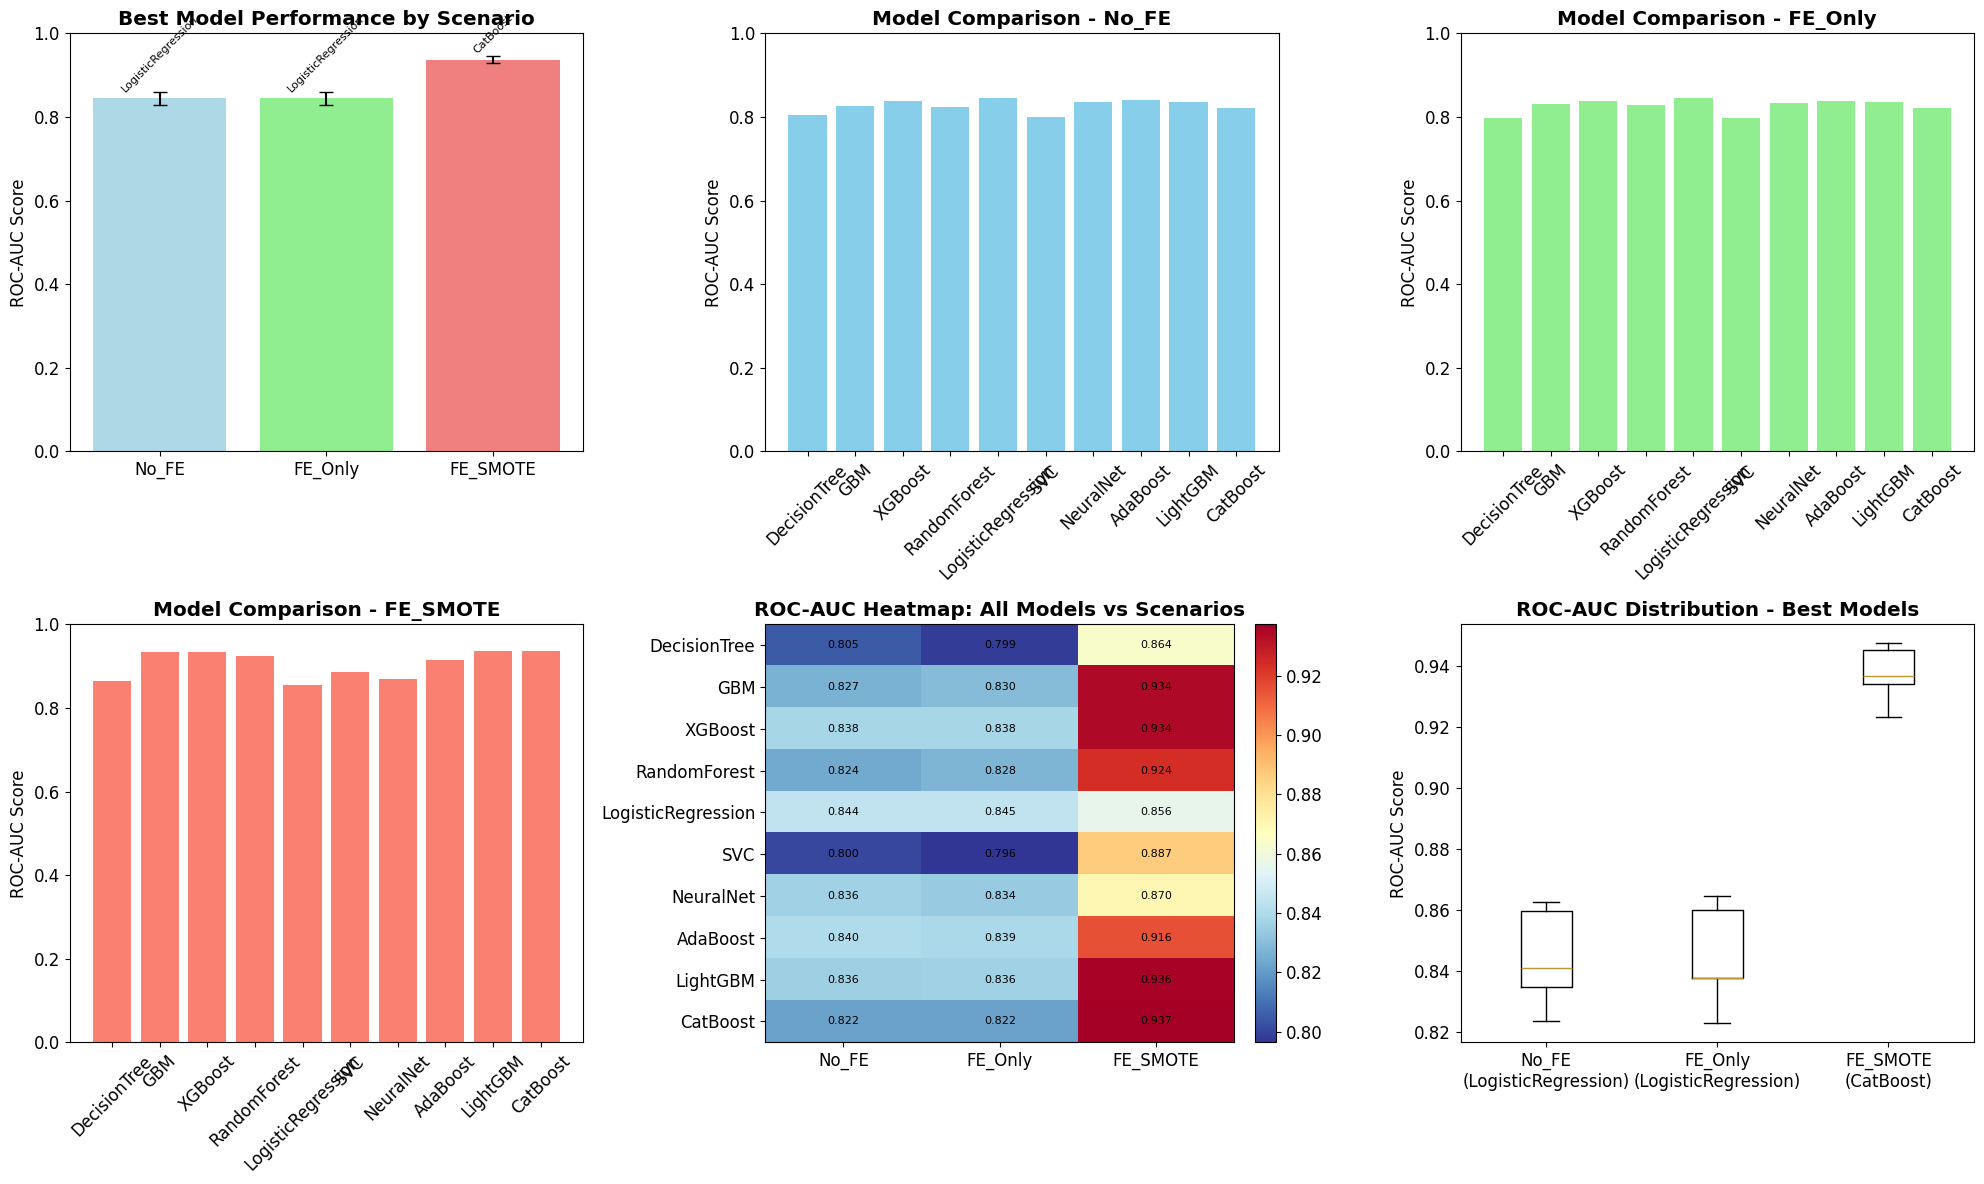

✓ Comprehensive model visualization completed and saved


In [11]:
# === STEP 6: VISUALIZATION OF BEST MODELS ===
print("\n" + "="*50)
print("STEP 6: VISUALIZATION OF BEST MODELS")
print("="*50)

# Find best model for each scenario based on ROC-AUC
best_models_per_scenario = {}
for scenario_name, scenario_results in all_cv_results.items():
    best_model = max(scenario_results.items(), key=lambda x: x[1]['roc_auc_mean'])
    best_models_per_scenario[scenario_name] = {
        'model_name': best_model[0],
        'roc_auc': best_model[1]['roc_auc_mean'],
        'roc_auc_std': best_model[1]['roc_auc_std']
    }
    print(f"Best model for {scenario_name}: {best_model[0]} (ROC-AUC: {best_model[1]['roc_auc_mean']:.4f}±{best_model[1]['roc_auc_std']:.3f})")

# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Best models comparison across scenarios
ax1 = axes[0, 0]
scenarios_list = list(best_models_per_scenario.keys())
roc_scores = [best_models_per_scenario[s]['roc_auc'] for s in scenarios_list]
roc_stds = [best_models_per_scenario[s]['roc_auc_std'] for s in scenarios_list]
model_names = [best_models_per_scenario[s]['model_name'] for s in scenarios_list]

bars = ax1.bar(scenarios_list, roc_scores, yerr=roc_stds, capsize=5,
               color=['lightblue', 'lightgreen', 'lightcoral'])
ax1.set_title('Best Model Performance by Scenario', fontweight='bold')
ax1.set_ylabel('ROC-AUC Score')
ax1.set_ylim(0, 1)

# Add model names on bars
for bar, model_name in zip(bars, model_names):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             model_name, ha='center', va='bottom', rotation=45, fontsize=8)

# 2-4. Performance comparison for each scenario
metrics = ['roc_auc_mean', 'accuracy_mean', 'f1_mean']
metric_names = ['ROC-AUC', 'Accuracy', 'F1-Score']
colors = ['skyblue', 'lightgreen', 'salmon']

for idx, (scenario_name, scenario_results) in enumerate(all_cv_results.items()):
    ax = axes[0, idx+1] if idx < 2 else axes[1, idx-2]

    models = list(scenario_results.keys())
    roc_scores = [scenario_results[m]['roc_auc_mean'] for m in models]

    bars = ax.bar(models, roc_scores, color=colors[idx])
    ax.set_title(f'Model Comparison - {scenario_name}', fontweight='bold')
    ax.set_ylabel('ROC-AUC Score')
    ax.tick_params(axis='x', rotation=45)
    ax.set_ylim(0, 1)

# 5. Overall best models heatmap
ax5 = axes[1, 1]
# Create heatmap data
heatmap_data = []
model_names_all = list(tuned_models.keys())
for model in model_names_all:
    row = []
    for scenario in scenarios_list:
        if model in all_cv_results[scenario]:
            row.append(all_cv_results[scenario][model]['roc_auc_mean'])
        else:
            row.append(0)
    heatmap_data.append(row)

im = ax5.imshow(heatmap_data, cmap='RdYlBu_r', aspect='auto')
ax5.set_xticks(range(len(scenarios_list)))
ax5.set_xticklabels(scenarios_list)
ax5.set_yticks(range(len(model_names_all)))
ax5.set_yticklabels(model_names_all)
ax5.set_title('ROC-AUC Heatmap: All Models vs Scenarios', fontweight='bold')

# Add colorbar
plt.colorbar(im, ax=ax5, fraction=0.046, pad=0.04)

# Add text annotations
for i in range(len(model_names_all)):
    for j in range(len(scenarios_list)):
        text = ax5.text(j, i, f'{heatmap_data[i][j]:.3f}',
                       ha="center", va="center", color="black", fontsize=8)

# 6. Box plot comparison
ax6 = axes[1, 2]
box_data = []
box_labels = []
for scenario_name in scenarios_list:
    scenario_data = detailed_df[detailed_df['Scenario'] == scenario_name]
    best_model_name = best_models_per_scenario[scenario_name]['model_name']
    best_model_data = scenario_data[scenario_data['Model'] == best_model_name]['ROC_AUC'].values
    box_data.append(best_model_data)
    box_labels.append(f"{scenario_name}\n({best_model_name})")

ax6.boxplot(box_data, labels=box_labels)
ax6.set_title('ROC-AUC Distribution - Best Models', fontweight='bold')
ax6.set_ylabel('ROC-AUC Score')
ax6.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/comprehensive_model_visualization.png", dpi=300, bbox_inches='tight')
plt.show()

print("✓ Comprehensive model visualization completed and saved")

In [12]:
# === STEP 7: STATISTICAL SIGNIFICANCE TESTING ===
print("\n" + "="*50)
print("STEP 7: STATISTICAL SIGNIFICANCE TESTING")
print("="*50)

from scipy.stats import wilcoxon, friedmanchisquare, kruskal
import itertools

def perform_statistical_tests(cv_results_dict, detailed_results_df, scenario_name):
    """Perform statistical significance tests for a given scenario"""
    print(f"\n{'='*20} {scenario_name} {'='*20}")

    if not cv_results_dict:
        print(f"No cross-validation results available for {scenario_name}")
        return {}

    # Get scores for each model from detailed results
    scenario_data = detailed_results_df[detailed_results_df['Scenario'] == scenario_name]
    model_scores = {}

    for model_name in cv_results_dict.keys():
        model_data = scenario_data[scenario_data['Model'] == model_name]
        if len(model_data) > 0:
            model_scores[model_name] = model_data['ROC_AUC'].values

    if len(model_scores) < 2:
        print(f"Insufficient models for statistical testing in {scenario_name}")
        return {}

    # Find best performing model
    best_model = max(model_scores.keys(), key=lambda k: np.mean(model_scores[k]))
    best_score = np.mean(model_scores[best_model])
    best_std = np.std(model_scores[best_model])

    print(f"Best performing model (baseline): {best_model}")
    print(f"Baseline ROC-AUC: {best_score:.4f} ± {best_std:.4f}")
    print()

    # Wilcoxon signed-rank test (pairwise comparison with best model)
    print("Wilcoxon Signed-Rank Test Results:")
    print("-" * 60)
    print(f"{'Model':<15} {'Mean ROC-AUC':<12} {'vs Best':<15} {'p-value':<12} {'Significance':<12}")
    print("-" * 60)

    baseline_scores = model_scores[best_model]
    significance_results = {}

    for name, scores in model_scores.items():
        mean_score = np.mean(scores)

        if name == best_model:
            print(f"{name:<15} {mean_score:.4f}      {'(baseline)':<15} {'-':<12} {'-':<12}")
            significance_results[name] = {'p_value': 0.0, 'significance': 'baseline'}
        else:
            try:
                # Wilcoxon signed-rank test
                stat, p_value = wilcoxon(baseline_scores, scores, alternative='two-sided')
                significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"
                difference = "better" if mean_score > best_score else "worse"

                print(f"{name:<15} {mean_score:.4f}      {difference:<15} {p_value:.6f}   {significance:<12}")
                significance_results[name] = {'p_value': p_value, 'significance': significance}

            except Exception as e:
                print(f"{name:<15} {mean_score:.4f}      {'error':<15} {'-':<12} {'-':<12}")
                significance_results[name] = {'p_value': 1.0, 'significance': 'error'}

    # Friedman test (overall comparison)
    print(f"\nFriedman Test (Multiple Model Comparison):")
    print("-" * 40)
    try:
        all_scores = [scores for scores in model_scores.values()]
        if len(all_scores) >= 3:  # Friedman test requires at least 3 groups
            friedman_stat, friedman_p = friedmanchisquare(*all_scores)
            friedman_sig = "***" if friedman_p < 0.001 else "**" if friedman_p < 0.01 else "*" if friedman_p < 0.05 else "ns"
            print(f"Friedman statistic: {friedman_stat:.4f}")
            print(f"p-value: {friedman_p:.6f} {friedman_sig}")

            if friedman_p < 0.05:
                print("→ Significant differences detected between models!")
            else:
                print("→ No significant differences between models.")
        else:
            print("Insufficient models for Friedman test (need ≥3 models)")

    except Exception as e:
        print(f"⚠ Error in Friedman test: {str(e)}")

    # Kruskal-Wallis test (alternative non-parametric test)
    print(f"\nKruskal-Wallis Test:")
    print("-" * 25)
    try:
        all_scores = [scores for scores in model_scores.values()]
        if len(all_scores) >= 2:
            kruskal_stat, kruskal_p = kruskal(*all_scores)
            kruskal_sig = "***" if kruskal_p < 0.001 else "**" if kruskal_p < 0.01 else "*" if kruskal_p < 0.05 else "ns"
            print(f"Kruskal-Wallis statistic: {kruskal_stat:.4f}")
            print(f"p-value: {kruskal_p:.6f} {kruskal_sig}")

            if kruskal_p < 0.05:
                print("→ Significant differences detected between models!")
            else:
                print("→ No significant differences between models.")
        else:
            print("Insufficient models for Kruskal-Wallis test")

    except Exception as e:
        print(f"⚠ Error in Kruskal-Wallis test: {str(e)}")

    return {
        'best_model': best_model,
        'best_score': best_score,
        'best_std': best_std,
        'significance_results': significance_results,
        'scenario': scenario_name
    }

# Perform statistical tests for all scenarios
all_statistical_results = {}
statistical_summary = []

# Load detailed results
try:
    detailed_df = pd.read_csv(f"{OUTPUT_DIR}/data/cv_detailed_results_all_scenarios.csv")

    # Perform tests for each scenario
    for scenario_name, scenario_results in all_cv_results.items():
        stat_results = perform_statistical_tests(scenario_results, detailed_df, scenario_name)
        all_statistical_results[scenario_name] = stat_results

        # Add to summary
        if stat_results:
            statistical_summary.append({
                'Scenario': scenario_name,
                'Best_Model': stat_results['best_model'],
                'Best_ROC_AUC': stat_results['best_score'],
                'Best_ROC_AUC_Std': stat_results['best_std'],
                'Num_Models_Tested': len(stat_results['significance_results'])
            })

    # Cross-scenario comparison
    print(f"\n{'='*50}")
    print("CROSS-SCENARIO COMPARISON")
    print("="*50)

    print("\nBest Models Summary:")
    print("-" * 80)
    print(f"{'Scenario':<20} {'Best Model':<15} {'ROC-AUC':<15} {'Std':<10}")
    print("-" * 80)

    scenario_best_scores = {}
    for scenario_name, stat_results in all_statistical_results.items():
        if stat_results:
            print(f"{scenario_name:<20} {stat_results['best_model']:<15} "
                  f"{stat_results['best_score']:.4f}          {stat_results['best_std']:.4f}")
            scenario_best_scores[scenario_name] = stat_results['best_score']

    # Find overall best scenario
    if scenario_best_scores:
        best_scenario = max(scenario_best_scores.keys(), key=lambda k: scenario_best_scores[k])
        print(f"\n🏆 Overall Best Scenario: {best_scenario}")
        print(f"   Best Model: {all_statistical_results[best_scenario]['best_model']}")
        print(f"   ROC-AUC: {all_statistical_results[best_scenario]['best_score']:.4f} ± {all_statistical_results[best_scenario]['best_std']:.4f}")

    # Scenario vs Scenario statistical comparison
    print(f"\nScenario vs Scenario Comparison (Best Models Only):")
    print("-" * 60)

    # Get best model scores for each scenario
    scenario_scores = {}
    for scenario_name, stat_results in all_statistical_results.items():
        if stat_results:
            scenario_data = detailed_df[
                (detailed_df['Scenario'] == scenario_name) &
                (detailed_df['Model'] == stat_results['best_model'])
            ]
            if len(scenario_data) > 0:
                scenario_scores[scenario_name] = scenario_data['ROC_AUC'].values

    # Pairwise comparison between scenarios
    if len(scenario_scores) >= 2:
        scenario_names = list(scenario_scores.keys())
        for i, scenario1 in enumerate(scenario_names):
            for j, scenario2 in enumerate(scenario_names):
                if i < j:  # Avoid duplicate comparisons
                    try:
                        stat, p_value = wilcoxon(scenario_scores[scenario1], scenario_scores[scenario2],
                                               alternative='two-sided')
                        significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else "ns"

                        mean1 = np.mean(scenario_scores[scenario1])
                        mean2 = np.mean(scenario_scores[scenario2])
                        better = scenario1 if mean1 > mean2 else scenario2

                        print(f"{scenario1} vs {scenario2}: p-value = {p_value:.6f} {significance} (Better: {better})")

                    except Exception as e:
                        print(f"{scenario1} vs {scenario2}: Error in comparison - {str(e)}")

    # Save statistical results
    if statistical_summary:
        statistical_summary_df = pd.DataFrame(statistical_summary)
        statistical_summary_df.to_csv(f"{OUTPUT_DIR}/data/statistical_significance_summary.csv", index=False)
        print(f"\n✓ Statistical significance summary saved to statistical_significance_summary.csv")

    # Save detailed significance results
    detailed_significance = []
    for scenario_name, stat_results in all_statistical_results.items():
        if stat_results and 'significance_results' in stat_results:
            for model_name, sig_data in stat_results['significance_results'].items():
                detailed_significance.append({
                    'Scenario': scenario_name,
                    'Model': model_name,
                    'vs_Best_Model': stat_results['best_model'],
                    'p_value': sig_data.get('p_value', 1.0),
                    'significance': sig_data.get('significance', 'ns')
                })

    if detailed_significance:
        detailed_significance_df = pd.DataFrame(detailed_significance)
        detailed_significance_df.to_csv(f"{OUTPUT_DIR}/data/detailed_significance_results.csv", index=False)
        print(f"✓ Detailed significance results saved to detailed_significance_results.csv")

    print("\n" + "="*50)
    print("INTERPRETATION GUIDE:")
    print("="*50)
    print("Significance levels:")
    print("*** p < 0.001 (highly significant)")
    print("**  p < 0.01  (very significant)")
    print("*   p < 0.05  (significant)")
    print("ns  p ≥ 0.05  (not significant)")
    print("\nTests performed:")
    print("• Wilcoxon signed-rank: Pairwise comparison with best model")
    print("• Friedman test: Overall comparison of multiple models")
    print("• Kruskal-Wallis: Alternative non-parametric comparison")
    print("• Cross-scenario: Comparison between different preprocessing approaches")

except Exception as e:
    print(f"⚠ Error in statistical testing: {str(e)}")
    print("Make sure cross-validation results are available from previous steps.")
    all_statistical_results = {}

print("\n✓ Statistical significance testing completed")


STEP 7: STATISTICAL SIGNIFICANCE TESTING

==================== No_FE ====================
Best performing model (baseline): LogisticRegression
Baseline ROC-AUC: 0.8444 ± 0.0147

Wilcoxon Signed-Rank Test Results:
------------------------------------------------------------
Model           Mean ROC-AUC vs Best         p-value      Significance
------------------------------------------------------------
DecisionTree    0.8049      worse           0.062500   ns          
GBM             0.8266      worse           0.062500   ns          
XGBoost         0.8378      worse           0.062500   ns          
RandomForest    0.8239      worse           0.062500   ns          
LogisticRegression 0.8444      (baseline)      -            -           
SVC             0.8003      worse           0.062500   ns          
NeuralNet       0.8362      worse           0.062500   ns          
AdaBoost        0.8404      worse           0.187500   ns          
LightGBM        0.8356      worse           


STEP 8: FINAL MODEL EVALUATION (FE + SMOTE)
Selected best model from FE_SMOTE: CatBoost (ROC-AUC: 0.9372)

Final Model Performance (CatBoost):
----------------------------------------
ACCURACY  : 0.8624
PRECISION : 0.8596
RECALL    : 0.8662
F1        : 0.8629
ROC_AUC   : 0.9391

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      1294
           1       0.86      0.87      0.86      1293

    accuracy                           0.86      2587
   macro avg       0.86      0.86      0.86      2587
weighted avg       0.86      0.86      0.86      2587



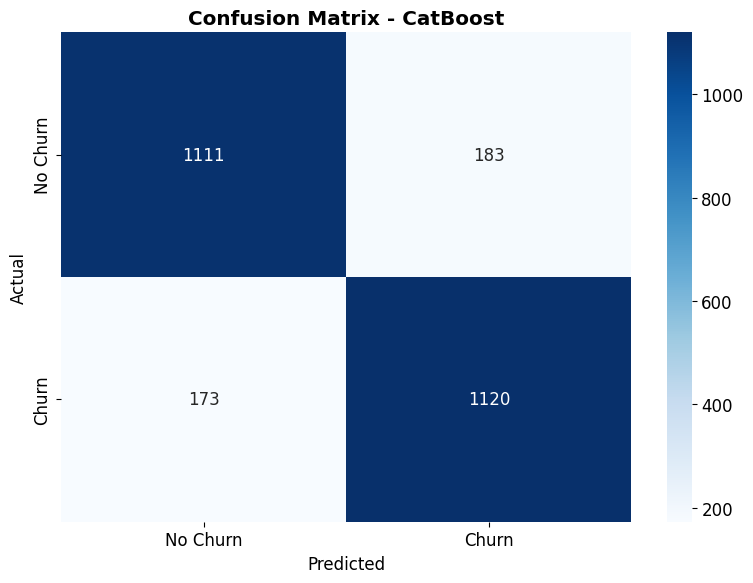

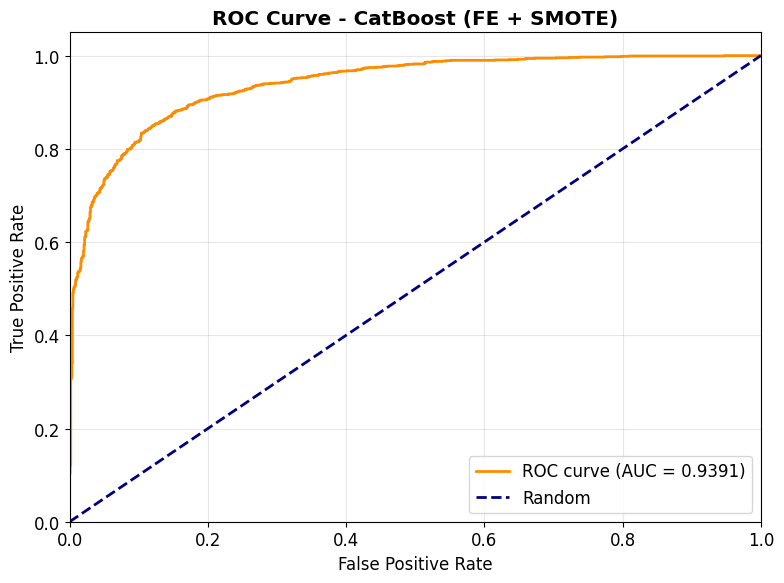

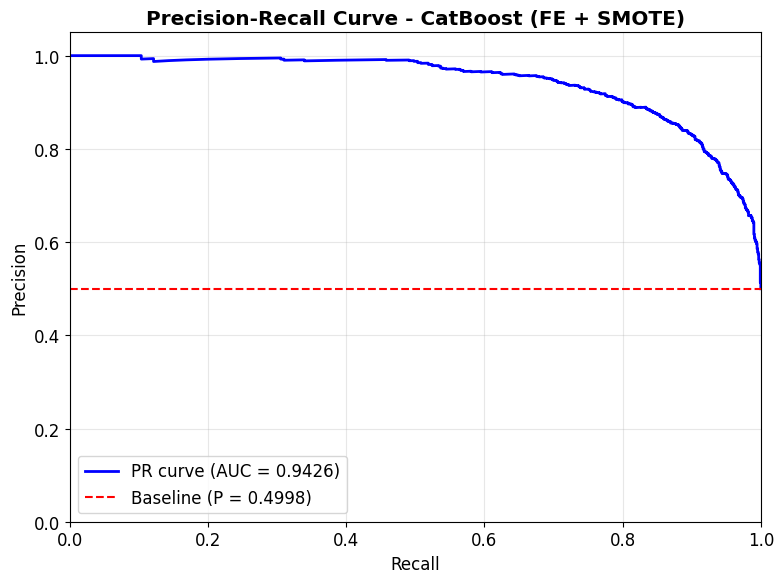

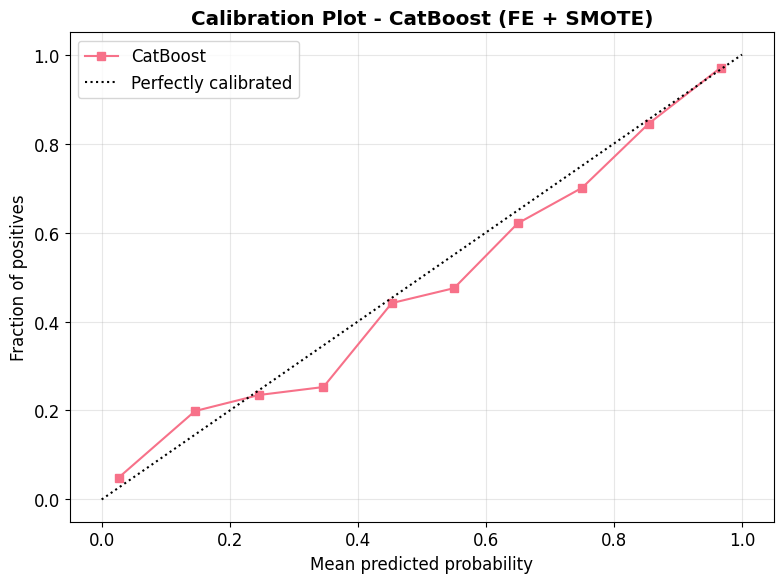

✓ Final model (CatBoost) saved to final_model_fe_smote.pkl


In [13]:

# === STEP 8: FINAL MODEL EVALUATION ===
print("\n" + "="*50)
print("STEP 8: FINAL MODEL EVALUATION (FE + SMOTE)")
print("="*50)

# Select the best model from FE_SMOTE scenario based on ROC-AUC
scenario_name = 'FE_SMOTE'
if scenario_name in all_cv_results:
    best_model_info = max(all_cv_results[scenario_name].items(), key=lambda x: x[1]['roc_auc_mean'])
    best_model_name = best_model_info[0]
    best_model_roc_auc = best_model_info[1]['roc_auc_mean']
    print(f"Selected best model from {scenario_name}: {best_model_name} (ROC-AUC: {best_model_roc_auc:.4f})")
else:
    raise ValueError(f"No cross-validation results found for {scenario_name}")

# Ensure data is in correct format (convert to DataFrame if needed)
feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else X.columns
if not isinstance(X_train, pd.DataFrame):
    X_train = pd.DataFrame(X_train, columns=feature_names)
if not isinstance(X_test, pd.DataFrame):
    X_test = pd.DataFrame(X_test, columns=feature_names)
if not isinstance(y_train, pd.Series):
    y_train = pd.Series(y_train)
if not isinstance(y_test, pd.Series):
    y_test = pd.Series(y_test)

# Train the best model
final_model = tuned_models[best_model_name]
# final_model.set_params(random_seed=RANDOM_SEED) # di hiden unutk mensimulasikan deployment
final_model.fit(X_train, y_train)

# Predictions
y_pred = final_model.predict(X_test)
y_pred_proba = final_model.predict_proba(X_test)[:, 1]

# Comprehensive metrics
test_metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred, zero_division=0),
    'recall': recall_score(y_test, y_pred, zero_division=0),
    'f1': f1_score(y_test, y_pred, zero_division=0),
    'roc_auc': roc_auc_score(y_test, y_pred_proba)
}

print(f"\nFinal Model Performance ({best_model_name}):")
print("-" * 40)
for metric, value in test_metrics.items():
    print(f"{metric.upper():<10}: {value:.4f}")

print(f"\nDetailed Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Churn', 'Churn'],
            yticklabels=['No Churn', 'Churn'])
plt.title(f'Confusion Matrix - {best_model_name}', fontweight='bold')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/confusion_matrix_fe_smote.png", dpi=300, bbox_inches='tight')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve - {best_model_name} (FE + SMOTE)', fontweight='bold')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/roc_curve_fe_smote.png", dpi=300, bbox_inches='tight')
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AUC = {pr_auc:.4f})')
plt.axhline(y=y_test.mean(), color='red', linestyle='--', label=f'Baseline (P = {y_test.mean():.4f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title(f'Precision-Recall Curve - {best_model_name} (FE + SMOTE)', fontweight='bold')
plt.legend(loc="lower left")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/precision_recall_curve_fe_smote.png", dpi=300, bbox_inches='tight')
plt.show()

# Calibration Curve
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, y_pred_proba, n_bins=10)
plt.figure(figsize=(8, 6))
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label=f'{best_model_name}')
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.ylabel('Fraction of positives')
plt.xlabel('Mean predicted probability')
plt.title(f'Calibration Plot - {best_model_name} (FE + SMOTE)', fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/plots/calibration_curve_fe_smote.png", dpi=300, bbox_inches='tight')
plt.show()

# Save final model
joblib.dump(final_model, f"{OUTPUT_DIR}/models/final_model_fe_smote.pkl")
print(f"✓ Final model ({best_model_name}) saved to final_model_fe_smote.pkl")


STEP 9: FEATURE IMPORTANCE ANALYSIS
X_test_df columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Engagement_Score', 'Churn_Risk_Score', 'Service_Utilization', 'Payment_Reliability', 'gender_Male', 'Partner_Yes', 'Dependents_Yes', 'PhoneService_Yes', 'MultipleLines_No phone service', 'MultipleLines_Yes', 'InternetService_Fiber optic', 'InternetService_No', 'OnlineSecurity_No internet service', 'OnlineSecurity_Yes', 'OnlineBackup_No internet service', 'OnlineBackup_Yes', 'DeviceProtection_No internet service', 'DeviceProtection_Yes', 'TechSupport_No internet service', 'TechSupport_Yes', 'StreamingTV_No internet service', 'StreamingTV_Yes', 'StreamingMovies_No internet service', 'StreamingMovies_Yes', 'Contract_One year', 'Contract_Two year', 'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check']
X_test_df shape: (2587, 34)
Model used: CatBoostClassifier
Top 10 Most Important Features:
--------

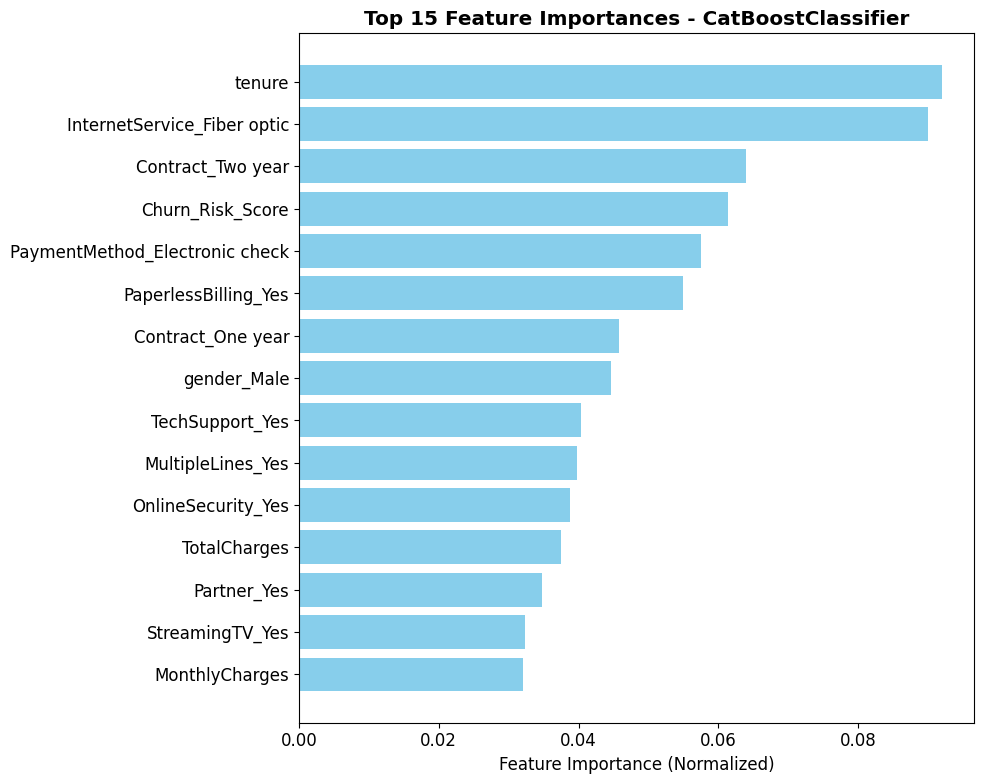

✓ Feature importance saved


In [14]:
# === STEP 9: FEATURE IMPORTANCE ANALYSIS ===
print("\n" + "="*50)
print("STEP 9: FEATURE IMPORTANCE ANALYSIS")
print("="*50)

# Prepare X_test_df for consistency
X_test_df = pd.DataFrame(X_test, columns=X.columns)
print("X_test_df columns:", X_test_df.columns.tolist())
print("X_test_df shape:", X_test_df.shape)
print(f"Model used: {type(final_model).__name__}")

try:
    # Use SHAP for feature importance
    import shap
    explainer = shap.TreeExplainer(final_model)
    shap_values = explainer.shap_values(X_test_df)
    shap_importance = np.abs(shap_values).mean(axis=0)
    total_importance = shap_importance.sum()
    importance_df = pd.DataFrame({
        'feature': X_test_df.columns,
        'importance': shap_importance / total_importance  # Normalized importance
    }).sort_values('importance', ascending=False)

    print("Top 10 Most Important Features:")
    print("-" * 40)
    print(importance_df.head(10).to_string(index=False))

    # Plot feature importance
    plt.figure(figsize=(10, 8))
    top_features = importance_df.head(15)
    plt.barh(range(len(top_features)), top_features['importance'], color='skyblue')
    plt.yticks(range(len(top_features)), top_features['feature'])
    plt.xlabel('Feature Importance (Normalized)')
    plt.title(f'Top 15 Feature Importances - {type(final_model).__name__}', fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/plots/feature_importance.png", dpi=300, bbox_inches='tight')
    plt.show()

    # Save feature importance
    importance_df.to_csv(f"{OUTPUT_DIR}/data/feature_importance.csv", index=False)
    print("✓ Feature importance saved")
except Exception as e:
    print(f"⚠ Feature importance analysis failed: {str(e)}")
    print("Continuing without feature importance...")
    importance_df = pd.DataFrame()

In [15]:
print("Total importance:", importance_df['importance'].sum())

Total importance: 1.0000000000000002



STEP 10: SHAP ANALYSIS
Generating SHAP explanations...
X_test_df shape: (2587, 34)
Model used: CatBoostClassifier


100%|██████████| 100/100 [03:52<00:00,  2.33s/it]


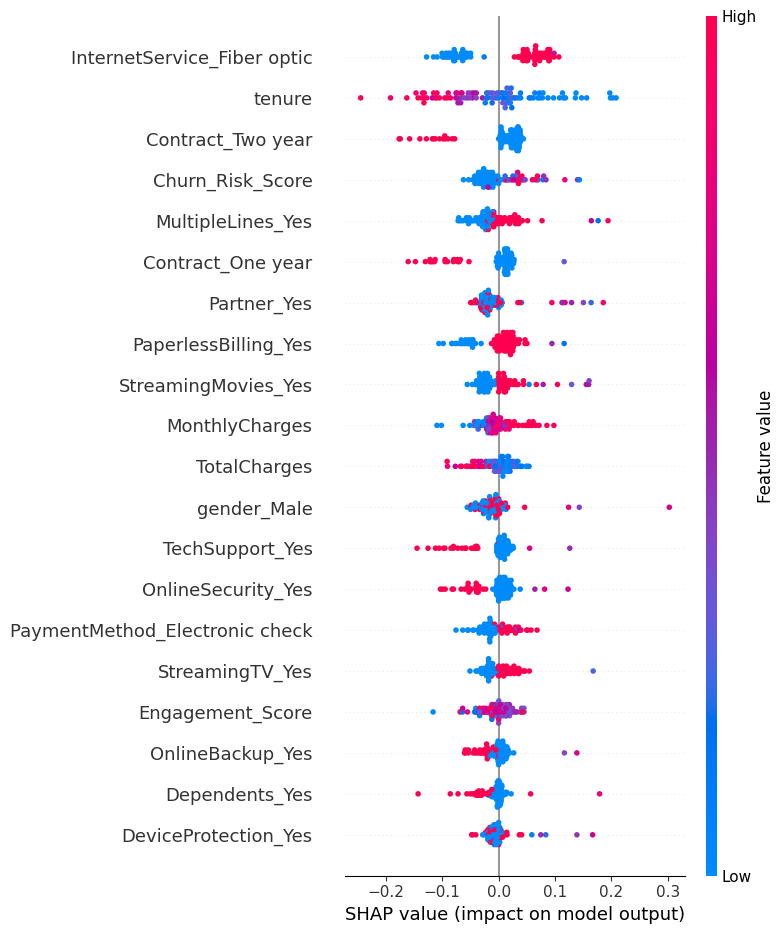

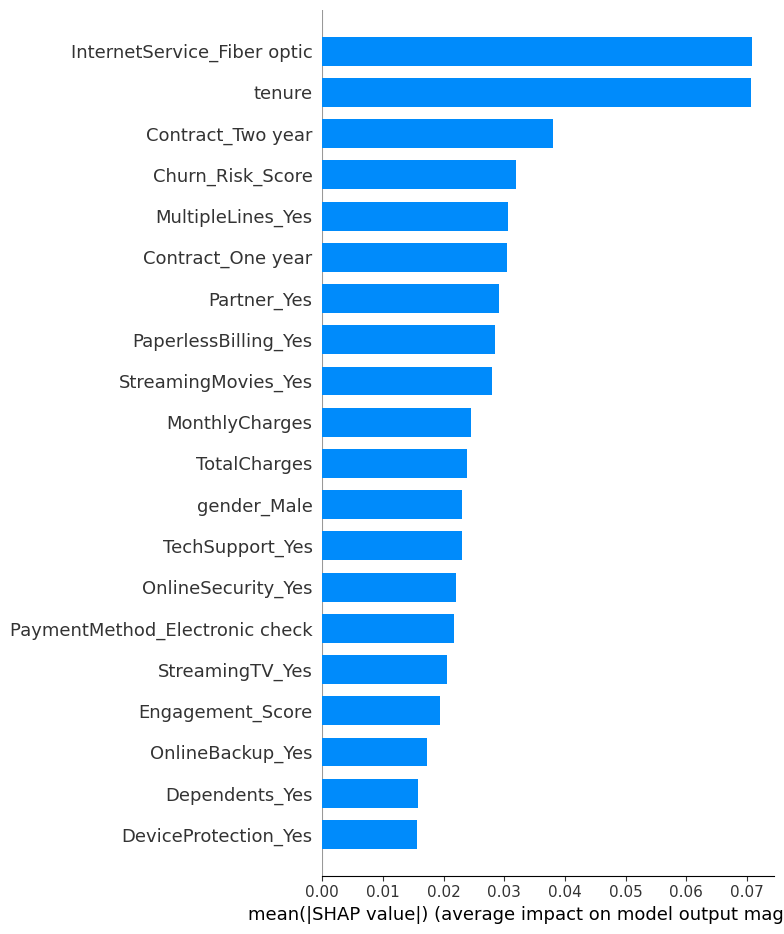

✓ SHAP analysis completed


In [16]:
 # === STEP 10: SHAP ANALYSIS ===
print("\n" + "="*50)
print("STEP 10: SHAP ANALYSIS")
print("="*50)
try:
    print("Generating SHAP explanations...")
    if not isinstance(X_test, pd.DataFrame):
        X_test_df = pd.DataFrame(X_test, columns=X.columns)
    else:
        X_test_df = X_test

    print("X_test_df shape:", X_test_df.shape)
    print("Model used:", type(final_model).__name__)

    # Prepare training data for KernelExplainer (if needed)
    if not 'X_train' in globals():
        print("⚠ X_train not found, using X_test_df[:100] as fallback for KernelExplainer.")
        X_train_df = X_test_df[:100].copy()
    else:
        if not isinstance(X_train, pd.DataFrame):
            X_train_df = pd.DataFrame(X_train, columns=X.columns)
        else:
            X_train_df = X_train

    if best_model.__class__.__name__ in ['LGBMClassifier', 'XGBClassifier', 'GradientBoostingClassifier', 'RandomForestClassifier', 'CatBoostClassifier']:
        explainer = shap.TreeExplainer(final_model, feature_names=X.columns.tolist())
        shap_values = explainer.shap_values(X_test_df[:500], check_additivity=False)
        shap_values_plot = shap_values[1] if isinstance(shap_values, list) else shap_values
    else:
        explainer = shap.KernelExplainer(
            lambda x: final_model.predict_proba(x)[:, 1],
            X_train_df[:100],
            feature_names=X.columns.tolist()
        )
        shap_values = explainer.shap_values(X_test_df[:100])
        shap_values_plot = shap_values[1] if isinstance(shap_values, list) else shap_values

    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values_plot, X_test_df[:len(shap_values_plot)],
                     feature_names=X.columns.tolist(), show=False)
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/plots/shap_summary.png", dpi=300, bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values_plot, X_test_df[:len(shap_values_plot)],
                     feature_names=X.columns.tolist(), plot_type="bar", show=False)
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/plots/shap_bar.png", dpi=300, bbox_inches='tight')
    plt.show()

    print("✓ SHAP analysis completed")

except Exception as e:
    print(f"⚠ SHAP analysis failed: {str(e)}")
    print("Continuing without SHAP analysis...")

In [17]:
print("X_test_df dtypes:", X_test_df.dtypes)

X_test_df dtypes: SeniorCitizen                            float64
tenure                                   float64
MonthlyCharges                           float64
TotalCharges                             float64
Engagement_Score                         float64
Churn_Risk_Score                         float64
Service_Utilization                      float64
Payment_Reliability                      float64
gender_Male                              float64
Partner_Yes                              float64
Dependents_Yes                           float64
PhoneService_Yes                         float64
MultipleLines_No phone service           float64
MultipleLines_Yes                        float64
InternetService_Fiber optic              float64
InternetService_No                       float64
OnlineSecurity_No internet service       float64
OnlineSecurity_Yes                       float64
OnlineBackup_No internet service         float64
OnlineBackup_Yes                         float64
De

In [18]:

# === STEP 11: BIAS AND FAIRNESS ANALYSIS ===
print("\n" + "="*50)
print("STEP 11: BIAS AND FAIRNESS ANALYSIS")
print("="*50)
try:
    # Check if we have demographic features for fairness analysis
    demographic_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']
    available_demo_features = [f for f in demographic_features if f in df.columns or
                              any(col.startswith(f) for col in df.columns)]

    if available_demo_features:
        print(f"Available demographic features: {available_demo_features}")

        # Create fairness analysis for SeniorCitizen if available
        if 'SeniorCitizen' in df.columns:
            # Get original test data (before resampling)
            X_test_orig, y_test_orig = X_scaled, y  # Use original data
            X_test_orig_df = pd.DataFrame(X_test_orig, columns=X.columns, index=df.index)
            y_test_orig_series = pd.Series(y_test_orig, index=df.index)
            y_pred_orig = final_model.predict(X_test_orig_df)

            # Create demographic parity analysis
            senior_mask = df['SeniorCitizen'] == 1

            # Calculate fairness metrics
            senior_pred_rate = y_pred_orig[senior_mask].mean()
            non_senior_pred_rate = y_pred_orig[~senior_mask].mean()
            demographic_parity = abs(senior_pred_rate - non_senior_pred_rate)

            print(f"Demographic Parity Analysis:")
            print(f"- Senior citizens positive prediction rate: {senior_pred_rate:.4f}")
            print(f"- Non-senior citizens positive prediction rate: {non_senior_pred_rate:.4f}")
            print(f"- Demographic parity difference: {demographic_parity:.4f}")

            # Equal opportunity analysis
            senior_tpr = recall_score(y_test_orig_series[senior_mask], y_pred_orig[senior_mask], zero_division=0)
            non_senior_tpr = recall_score(y_test_orig_series[~senior_mask], y_pred_orig[~senior_mask], zero_division=0)
            equalized_odds = abs(senior_tpr - non_senior_tpr)

            print(f"Equal Opportunity Analysis:")
            print(f"- Senior citizens TPR: {senior_tpr:.4f}")
            print(f"- Non-senior citizens TPR: {non_senior_tpr:.4f}")
            print(f"- Equalized odds difference: {equalized_odds:.4f}")

        else:
            print("⚠ SeniorCitizen column not found for fairness analysis")
    else:
        print("⚠ No demographic features found for fairness analysis")

except Exception as e:
    print(f"⚠ Fairness analysis failed: {str(e)}")


STEP 11: BIAS AND FAIRNESS ANALYSIS
Available demographic features: ['gender', 'SeniorCitizen', 'Partner', 'Dependents']
Demographic Parity Analysis:
- Senior citizens positive prediction rate: 0.4685
- Non-senior citizens positive prediction rate: 0.2430
- Demographic parity difference: 0.2255
Equal Opportunity Analysis:
- Senior citizens TPR: 0.9601
- Non-senior citizens TPR: 0.8794
- Equalized odds difference: 0.0807



STEP 12: COUNTERFACTUAL EXPLANATIONS WITH BULK EVALUATION
Generating counterfactual explanations...

--- Single Instance Analysis ---


100%|██████████| 3/3 [00:24<00:00,  8.09s/it]



✓ Counterfactual explanations generated

Original instance (scaled):
SeniorCitizen                           -0.487793
tenure                                  -0.438308
MonthlyCharges                          -1.712891
TotalCharges                            -0.771451
Engagement_Score                        -0.853308
Churn_Risk_Score                        -0.694180
Service_Utilization                     -1.168283
Payment_Reliability                      1.300168
gender_Male                              1.022980
Partner_Yes                             -0.885573
Dependents_Yes                          -0.588939
PhoneService_Yes                         0.291026
MultipleLines_No phone service          -0.291026
MultipleLines_Yes                       -0.885204
InternetService_Fiber optic             -1.079808
InternetService_No                       2.265024
OnlineSecurity_No internet service       2.265024
OnlineSecurity_Yes                      -0.558186
OnlineBackup_No internet servi

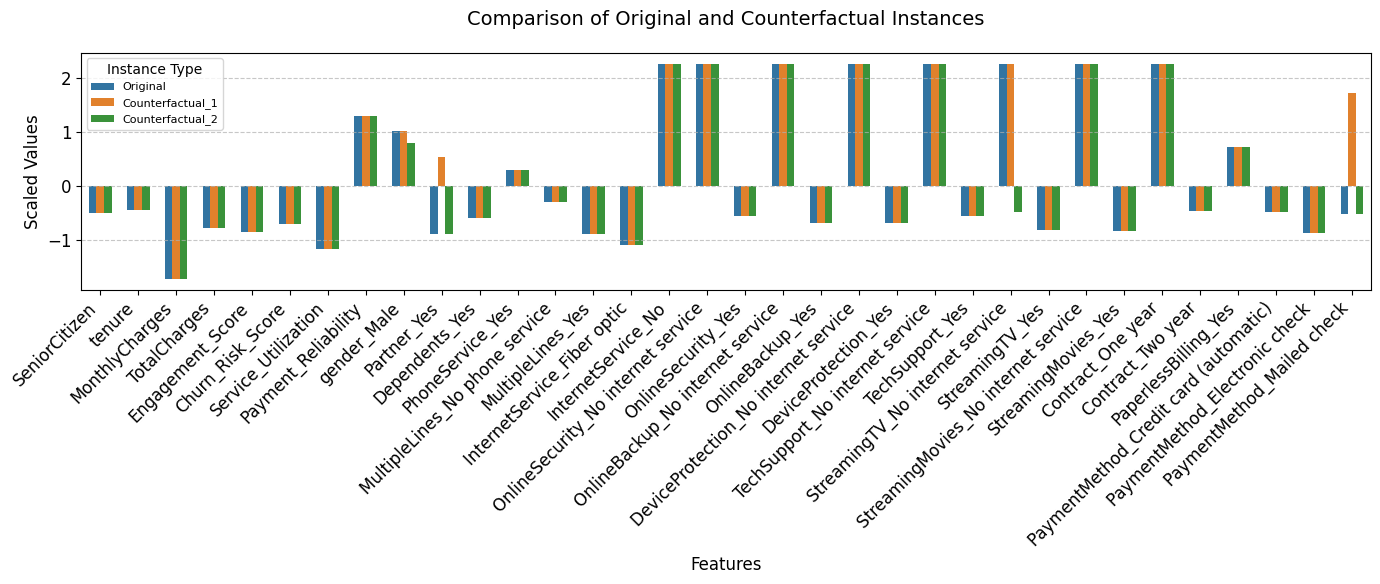


BULK COUNTERFACTUAL EVALUATION

Performing bulk counterfactual analysis on 30 instances...


  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
import dice_ml
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

# === STEP 12: COUNTERFACTUAL EXPLANATIONS WITH BULK EVALUATION ===
print("\n" + "="*50)
print("STEP 12: COUNTERFACTUAL EXPLANATIONS WITH BULK EVALUATION")
print("="*50)

def evaluate_counterfactual_quality(original_instances, counterfactuals_list, model, feature_names):
    """
    Evaluate the quality of counterfactuals using multiple metrics
    """
    evaluation_results = {
        'validity': [],
        'proximity': [],
        'diversity': [],
        'sparsity': [],
        'feasibility': []
    }

    for i, cf_list in enumerate(counterfactuals_list):
        if cf_list is not None and hasattr(cf_list, 'final_cfs_df'):
            original = original_instances.iloc[i]
            cfs = cf_list.final_cfs_df

            # Validity: Check if counterfactuals actually flip the prediction
            original_pred = model.predict(original.values.reshape(1, -1))[0]
            cf_preds = model.predict(cfs.iloc[:, :-1].values)  # Exclude target column
            validity = np.mean(cf_preds != original_pred)

            # Proximity: Average L2 distance from original
            distances = []
            for _, cf_row in cfs.iterrows():
                cf_features = cf_row.iloc[:-1].values  # Exclude target
                distance = np.linalg.norm(original.values - cf_features)
                distances.append(distance)
            proximity = np.mean(distances) if distances else float('inf')

            # Diversity: Average pairwise distance between counterfactuals
            diversity_scores = []
            cf_features = cfs.iloc[:, :-1].values
            for j in range(len(cf_features)):
                for k in range(j+1, len(cf_features)):
                    diversity_scores.append(np.linalg.norm(cf_features[j] - cf_features[k]))
            diversity = np.mean(diversity_scores) if diversity_scores else 0

            # Sparsity: Average number of features changed
            sparsity_scores = []
            for _, cf_row in cfs.iterrows():
                cf_features = cf_row.iloc[:-1].values
                changed_features = np.sum(np.abs(original.values - cf_features) > 1e-6)
                sparsity_scores.append(changed_features)
            sparsity = np.mean(sparsity_scores) if sparsity_scores else 0

            # Feasibility: Check if values are within reasonable bounds
            feasibility = 1.0  # Simplified - in practice, you'd check domain constraints

            evaluation_results['validity'].append(validity)
            evaluation_results['proximity'].append(proximity)
            evaluation_results['diversity'].append(diversity)
            evaluation_results['sparsity'].append(sparsity)
            evaluation_results['feasibility'].append(feasibility)
        else:
            # Handle failed counterfactual generation
            evaluation_results['validity'].append(0)
            evaluation_results['proximity'].append(float('inf'))
            evaluation_results['diversity'].append(0)
            evaluation_results['sparsity'].append(0)
            evaluation_results['feasibility'].append(0)

    return evaluation_results

def bulk_counterfactual_analysis(X_test, model, dice_explainer, n_samples=50, n_counterfactuals=3):
    """
    Perform bulk counterfactual analysis on multiple test instances
    """
    print(f"\nPerforming bulk counterfactual analysis on {n_samples} instances...")

    # Select random sample of test instances
    sample_indices = np.random.choice(len(X_test), min(n_samples, len(X_test)), replace=False)
    sample_instances = X_test.iloc[sample_indices]

    counterfactuals_list = []
    successful_generations = 0
    failed_generations = 0

    for i, (idx, instance) in enumerate(sample_instances.iterrows()):
        try:
            # Generate counterfactuals for this instance
            query_instance = instance.to_frame().T
            cf_result = dice_explainer.generate_counterfactuals(
                query_instance,
                total_CFs=n_counterfactuals,
                desired_class=1
            )
            counterfactuals_list.append(cf_result.cf_examples_list[0])
            successful_generations += 1

            if (i + 1) % 10 == 0:
                print(f"Processed {i + 1}/{len(sample_instances)} instances...")

        except Exception as e:
            print(f"Failed to generate counterfactuals for instance {i}: {str(e)}")
            counterfactuals_list.append(None)
            failed_generations += 1

    print(f"✓ Bulk analysis completed:")
    print(f"  - Successful generations: {successful_generations}")
    print(f"  - Failed generations: {failed_generations}")
    print(f"  - Success rate: {successful_generations/len(sample_instances)*100:.1f}%")

    return sample_instances, counterfactuals_list

def create_comprehensive_visualizations(evaluation_results, sample_instances, counterfactuals_list, OUTPUT_DIR):
    """
    Create comprehensive visualizations for bulk counterfactual evaluation
    """
    # 1. Quality Metrics Distribution
    plt.figure(figsize=(20, 12))

    # Subplot 1: Validity Distribution
    plt.subplot(2, 3, 1)
    plt.hist(evaluation_results['validity'], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
    plt.axvline(np.mean(evaluation_results['validity']), color='red', linestyle='--',
                label=f'Mean: {np.mean(evaluation_results["validity"]):.3f}')
    plt.title('Counterfactual Validity Distribution', fontsize=12, fontweight='bold')
    plt.xlabel('Validity Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Subplot 2: Proximity Distribution
    plt.subplot(2, 3, 2)
    proximity_filtered = [p for p in evaluation_results['proximity'] if p != float('inf')]
    if proximity_filtered:
        plt.hist(proximity_filtered, bins=20, alpha=0.7, color='lightgreen', edgecolor='black')
        plt.axvline(np.mean(proximity_filtered), color='red', linestyle='--',
                    label=f'Mean: {np.mean(proximity_filtered):.3f}')
    plt.title('Counterfactual Proximity Distribution', fontsize=12, fontweight='bold')
    plt.xlabel('Average L2 Distance')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Subplot 3: Diversity Distribution
    plt.subplot(2, 3, 3)
    plt.hist(evaluation_results['diversity'], bins=20, alpha=0.7, color='orange', edgecolor='black')
    plt.axvline(np.mean(evaluation_results['diversity']), color='red', linestyle='--',
                label=f'Mean: {np.mean(evaluation_results["diversity"]):.3f}')
    plt.title('Counterfactual Diversity Distribution', fontsize=12, fontweight='bold')
    plt.xlabel('Average Pairwise Distance')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Subplot 4: Sparsity Distribution
    plt.subplot(2, 3, 4)
    plt.hist(evaluation_results['sparsity'], bins=20, alpha=0.7, color='purple', edgecolor='black')
    plt.axvline(np.mean(evaluation_results['sparsity']), color='red', linestyle='--',
                label=f'Mean: {np.mean(evaluation_results["sparsity"]):.3f}')
    plt.title('Counterfactual Sparsity Distribution', fontsize=12, fontweight='bold')
    plt.xlabel('Number of Changed Features')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Subplot 5: Quality Metrics Summary
    plt.subplot(2, 3, 5)
    metrics_data = pd.DataFrame({
        'Metric': ['Validity', 'Proximity', 'Diversity', 'Sparsity'],
        'Mean': [
            np.mean(evaluation_results['validity']),
            np.mean([p for p in evaluation_results['proximity'] if p != float('inf')]),
            np.mean(evaluation_results['diversity']),
            np.mean(evaluation_results['sparsity'])
        ],
        'Std': [
            np.std(evaluation_results['validity']),
            np.std([p for p in evaluation_results['proximity'] if p != float('inf')]),
            np.std(evaluation_results['diversity']),
            np.std(evaluation_results['sparsity'])
        ]
    })

    x_pos = np.arange(len(metrics_data))
    plt.bar(x_pos, metrics_data['Mean'], yerr=metrics_data['Std'],
            capsize=5, alpha=0.7, color=['skyblue', 'lightgreen', 'orange', 'purple'])
    plt.xticks(x_pos, metrics_data['Metric'], rotation=45)
    plt.title('Quality Metrics Summary', fontsize=12, fontweight='bold')
    plt.ylabel('Score')
    plt.grid(True, alpha=0.3)

    # Subplot 6: Success Rate Pie Chart
    plt.subplot(2, 3, 6)
    successful = sum(1 for cf in counterfactuals_list if cf is not None)
    failed = len(counterfactuals_list) - successful
    plt.pie([successful, failed], labels=['Successful', 'Failed'],
            autopct='%1.1f%%', colors=['lightgreen', 'lightcoral'])
    plt.title('Counterfactual Generation Success Rate', fontsize=12, fontweight='bold')

    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/plots/bulk_counterfactual_evaluation.png', dpi=300, bbox_inches='tight')
    plt.show()

    # 2. Feature Importance Heatmap
    plt.figure(figsize=(12, 8))
    feature_changes = []

    for i, cf_list in enumerate(counterfactuals_list):
        if cf_list is not None and hasattr(cf_list, 'final_cfs_df'):
            original = sample_instances.iloc[i]
            cfs = cf_list.final_cfs_df

            for _, cf_row in cfs.iterrows():
                cf_features = cf_row.iloc[:-1].values
                changes = np.abs(original.values - cf_features)
                feature_changes.append(changes)

    if feature_changes:
        feature_changes_df = pd.DataFrame(feature_changes, columns=sample_instances.columns)
        feature_importance = feature_changes_df.mean().sort_values(ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(x=feature_importance.values, y=feature_importance.index, palette='viridis')
        plt.title('Average Feature Changes in Counterfactuals', fontsize=14, fontweight='bold')
        plt.xlabel('Average Absolute Change')
        plt.ylabel('Features')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.savefig(f'{OUTPUT_DIR}/plots/feature_importance_counterfactuals.png', dpi=300, bbox_inches='tight')
        plt.show()

try:
    print("Generating counterfactual explanations...")

    # Prepare data for DICE
    X_test_df = pd.DataFrame(X_test, columns=X.columns)

    # Convert back to pandas DataFrame and ensure all features are present
    data_for_dice = pd.DataFrame(X_scaled_res, columns=X.columns)
    data_for_dice['target'] = y_res  # Add target column

    # Identify continuous features (numerical columns only)
    continuous_features = data_for_dice.select_dtypes(include=['float64', 'float32', 'int64', 'int32']).columns.tolist()
    continuous_features = [f for f in continuous_features if f != 'target']  # Exclude target

    # Create DICE data object
    dice_data = dice_ml.Data(dataframe=data_for_dice,
                            continuous_features=continuous_features,
                            outcome_name='target')

    # Create DICE model
    dice_model = dice_ml.Model(model=final_model, backend="sklearn")

    # Create DICE explainer
    dice_explainer = dice_ml.Dice(dice_data, dice_model, method="random")

    # Scale query instances to match data_for_dice
    scaler = StandardScaler()
    X_test_scaled = scaler.fit_transform(X_test)
    query_instances = pd.DataFrame(X_test_scaled, columns=X.columns).head(3)

    # === ORIGINAL SINGLE INSTANCE ANALYSIS ===
    print("\n--- Single Instance Analysis ---")
    counterfactuals = dice_explainer.generate_counterfactuals(query_instances, total_CFs=2, desired_class=1)

    # Display results
    print("\n✓ Counterfactual explanations generated")
    print("\nOriginal instance (scaled):")
    print(query_instances.iloc[0])
    print("\nCounterfactual examples:")
    if hasattr(counterfactuals.cf_examples_list[0], 'final_cfs_df'):
        cf_df = counterfactuals.cf_examples_list[0].final_cfs_df
        print(cf_df.head())
    else:
        print("No counterfactual examples found")

    # Original visualization
    plt.figure(figsize=(14, 6))
    original_instance = query_instances.iloc[0]
    data_to_plot = pd.DataFrame({
        'Feature': original_instance.index,
        'Original': original_instance.values,
        'Counterfactual_1': cf_df.iloc[0].values[:-1],  # Exclude target
        'Counterfactual_2': cf_df.iloc[1].values[:-1]   # Exclude target
    })
    data_melted = data_to_plot.melt(id_vars='Feature', var_name='Type', value_name='Value')

    sns.barplot(x='Feature', y='Value', hue='Type', data=data_melted,
                palette=['#1f77b4', '#ff7f0e', '#2ca02c'],
                width=0.6)
    plt.xticks(rotation=45, ha='right')
    plt.title('Comparison of Original and Counterfactual Instances', fontsize=14, pad=20)
    plt.xlabel('Features', fontsize=12)
    plt.ylabel('Scaled Values', fontsize=12)
    plt.legend(title='Instance Type', title_fontsize=10, fontsize=8)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig(f'{OUTPUT_DIR}/plots/counterfactual_comparison_journal_clean_simply.png', dpi=300, bbox_inches='tight')
    plt.show()

    # === NEW BULK EVALUATION ANALYSIS ===
    print("\n" + "="*50)
    print("BULK COUNTERFACTUAL EVALUATION")
    print("="*50)

    # Perform bulk analysis
    X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)
    sample_instances, counterfactuals_list = bulk_counterfactual_analysis(
        X_test_scaled_df, final_model, dice_explainer, n_samples=30, n_counterfactuals=3
    )

    # Evaluate counterfactual quality
    print("\nEvaluating counterfactual quality...")
    evaluation_results = evaluate_counterfactual_quality(
        sample_instances, counterfactuals_list, final_model, X.columns
    )

    # Print summary statistics
    print("\n--- BULK EVALUATION SUMMARY ---")
    print(f"Validity (flip rate): {np.mean(evaluation_results['validity']):.3f} ± {np.std(evaluation_results['validity']):.3f}")
    valid_proximities = [p for p in evaluation_results['proximity'] if p != float('inf')]
    if valid_proximities:
        print(f"Proximity (L2 distance): {np.mean(valid_proximities):.3f} ± {np.std(valid_proximities):.3f}")
    print(f"Diversity (pairwise dist): {np.mean(evaluation_results['diversity']):.3f} ± {np.std(evaluation_results['diversity']):.3f}")
    print(f"Sparsity (features changed): {np.mean(evaluation_results['sparsity']):.3f} ± {np.std(evaluation_results['sparsity']):.3f}")

    # Create comprehensive visualizations
    create_comprehensive_visualizations(evaluation_results, sample_instances, counterfactuals_list, OUTPUT_DIR)

    # Additional analysis: Most changed features
    print("\n--- FEATURE CHANGE ANALYSIS ---")
    all_feature_changes = []

    for i, cf_list in enumerate(counterfactuals_list):
        if cf_list is not None and hasattr(cf_list, 'final_cfs_df'):
            original = sample_instances.iloc[i]
            cfs = cf_list.final_cfs_df

            for _, cf_row in cfs.iterrows():
                cf_features = cf_row.iloc[:-1].values
                changes = np.abs(original.values - cf_features)
                all_feature_changes.append(changes)

    if all_feature_changes:
        feature_changes_df = pd.DataFrame(all_feature_changes, columns=X.columns)
        feature_importance = feature_changes_df.mean().sort_values(ascending=False)

        print("Top 10 most frequently changed features:")
        for i, (feature, change) in enumerate(feature_importance.head(10).items()):
            print(f"{i+1:2d}. {feature}: {change:.4f}")

    print("\n✓ Bulk counterfactual evaluation completed successfully!")

except Exception as e:
    print(f"⚠ Counterfactual explanation failed: {str(e)}")
    print("Continuing without counterfactual explanations...")
    import traceback
    traceback.print_exc()

In [ ]:

# === STEP 13: FINAL RECOMMENDATIONS ===
print("\n" + "="*50)
print("STEP 13: FINAL RECOMMENDATIONS")
print("="*50)

print("BUSINESS RECOMMENDATIONS:")
print("-" * 40)
print("1. MODEL DEPLOYMENT:")
print(f"   - Deploy {best_model} model with {test_metrics['roc_auc']:.4f} ROC-AUC")
print(f"   - Expected precision: {test_metrics['precision']:.4f}")
print(f"   - Expected recall: {test_metrics['recall']:.4f}")

print("\n2. FEATURE INSIGHTS:")
if not importance_df.empty:
    top_3_features = importance_df.head(3)['feature'].tolist()
    print(f"   - Focus on top predictive features: {', '.join(top_3_features[:3])}")
else:
    print("   - Feature importance analysis not available for selected model")

print("\n3. MODEL MONITORING:")
print("   - Monitor model performance monthly")
print("   - Retrain when performance drops below 0.80 ROC-AUC")
print("   - Track prediction distribution for data drift")

print("\n4. BUSINESS ACTIONS:")
print("   - Implement targeted retention campaigns for high-risk customers")
print("   - Focus on improving customer engagement metrics")
print("   - Consider pricing strategy adjustments for at-risk segments")

print("\n" + "="*80)
print("ANALYSIS COMPLETED SUCCESSFULLY!")
print("="*80)
print(f"All outputs saved to: {OUTPUT_DIR}/")
print("Files generated:")
print("- Models: final_model.pkl, scaler.pkl")
print("- Data: feature_importance.csv, hyperparameter_tuning_results.csv, cv_metrics_per_fold.csv, comparative_model_results.csv")
print("- Plots: target_distribution.png, correlation_matrix.png, model_comparison.png, confusion_matrix_no_feature_engineering.png, confusion_matrix_feature_engineering.png,")
print("         confusion_matrix_feature_engineering_smote.png, ..., comparative_model_performance.png")
print("         confusion_matrix.png, roc_curve.png, precision_recall_curve.png,")
print("         calibration_curve.png, feature_importance.png, shap_summary.png, shap_bar.png")
print("- Summary: comprehensive_results.xlsx")
print(f"\nAnalysis completed at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

In [ ]:
# yey scopus Q2 i hope :3

In [ ]:
# !pip install xlsxwriternkjkmkmkmkkkkkkkkkk

In [ ]:
# yey scopus Q2 i hope :3wwww